# EventBasedBacktester

A flexible event-based backtesting framework for trading strategies, supporting market order execution with customizable parameters and comprehensive performance analysis.

## Features

- Event-driven architecture for testing trading strategies
- Support for market orders (long/short positions)
- Transaction cost modeling
- Comprehensive performance metrics and visualization
- Integration with yfinance for historical data

## Constructor Parameters

```python
EventBasedBacktester(symbol: str, start: str, end: str, interval: str, transaction_fee: float, verbose: bool = True)
```

- `symbol`: Trading instrument symbol (e.g., "AAPL")
- `start`: Start date for backtesting
- `end`: End date for backtesting
- `interval`: Time interval for data (e.g., "1d", "1h")
- `transaction_fee`: Transaction fee as a decimal (e.g., 0.001 for 0.1%)
- `verbose`: Toggle detailed logging output

## Key Methods

### Strategy Implementation
- `strategy(row)`: Abstract method to be overridden with custom trading logic
- `run_strategy()`: Executes the trading strategy across the historical data

### Trade Execution
- `execute_order(timestamp, position, quantity, type)`: Execute a market order
- `long_all(timestamp)`: Enter a long position with all available capital
- `short_all(timestamp)`: Enter a short position with all available capital
- `close_current_position(timestamp)`: Close the current position completely

### Performance Analysis
- `get_performance()`: Calculate key performance metrics
- `print_performance_summary()`: Display formatted performance metrics
- `plot_strategy_performance()`: Generate comprehensive performance visualizations

## Performance Metrics

- Total return and annual returns
- Risk metrics (Sharpe ratio, Sortino ratio, maximum drawdown)
- Volatility measures (annual standard deviation)
- Trade statistics
- Equity curve and drawdown analysis

## Example Usage

```python
class MyStrategy(EventBasedBacktester):
    def strategy(self, row):
        # Implement your trading logic here
        pass

# Initialize and run backtester
backtester = MyStrategy(
    symbol="AAPL",
    start="2023-01-01",
    end="2023-12-31",
    interval="1d",
    transaction_fee=0.001
)
backtester.set_capital(10000)  # Set initial capital
backtester.run_strategy()      # Execute strategy
backtester.print_performance_summary()  # View results
```

In [1]:
from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from typing import Optional, Union, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

class OrderType(Enum):
    MARKET = "MARKET"
    # LIMIT = "LIMIT"
    # STOP = "STOP"

# A trade is an order that has been executed. Assume that all trades were executed immediately.
@dataclass
class Trade:
    timestamp : int
    datetime : datetime
    position: int
    type: OrderType
    quantity: float
    price: float
    transaction_cost: float

@dataclass
class StrategyPerformance:
    symbol: str
    timestamp : int
    datetime : datetime
    position : int
    quantity: float
    price: float
    transaction_cost: float
    intial_capital : float
    realized_balance: float
    unrealized_balance: float
    total_balance: float
@dataclass
class ReturnsPerformance:
    symbol: str
    timestamp : int
    datetime: datetime
    position: int
    price: float
    total_balance : float

    # Calculated in performance
    # capital_regular_returns: float
    # capital_log_returns: float
    # capital_returns_logcumsum: float

class EventBasedBacktester:
    """
    Event based backtest for generic trading strategy.
    """
    def __init__(self, symbol, start, end, interval, transaction_fee, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.interval = interval
        self.data = self.prepare_data()
        if self.data.empty:
            raise ValueError(f"DATA IS EMPTY FOR {symbol}")

        """
        Trade settings
        """
        self.transaction_fee = transaction_fee
        self.initial_capital = None

        """
        Performance values.
        """
        self.current_position = 0
        self.current_capital = None
        self.transaction_costs = 0
        self.trades: List[Trade] = []
        self.strategy_performance: List[StrategyPerformance] = []
        self.returns_performance: List[ReturnsPerformance] = []

        """
        Miscellanous
        """
        self.minimum_balance = None
        self.stop_trading = False
        self.verbose = verbose

        self.has_run = False

    def set_capital(self, capital):
        """
        Set the capital for the strategy. This should be called before running the strategy.
        """
        self.initial_capital = capital
        self.current_capital = capital
        self.minimum_balance = capital * 0.1
        if self.verbose == True:
            print(f"Initial Capital set to {capital}")

    def prepare_data(self):
        """
        Ensure data is in correct format with proper column names
        """
        stock_data = yf.Ticker(self.symbol)
        data = stock_data.history(start=self.start, end=self.end, interval=self.interval
                                #   , auto_adjust=False
                                  ).reset_index().rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume',
            'Date': 'datetime'
        })
        data['timestamp'] = data['datetime'].apply(lambda x: int(x.timestamp() * 1000))
        data = data.sort_values('timestamp', ascending=True).reset_index(drop=True)
        data['logreturns_close'] = np.log(data['close'] / data['close'].shift(1))
        data['returns_close'] = (data['close'] / data['close'].shift(1)) - 1
        return data
    """
    Strategy Function - to override strategy() method.
    """
    def strategy(self, row):
        # Should use the execute_order() method to execute trades.
        raise NotImplementedError("Implement the strategy method")

    def run_strategy(self):
        if self.has_run:
            return
        self.has_run = True
        
        if self.initial_capital is None:
            self.set_capital(10000)
            print("INITIAL CAPITAL NOT SET. SETTING TO DEFAULT $10,000")
        for i, r in self.data.iterrows():
            # Check balance
            self.check_balance(timestamp=r['timestamp'])
            if self.stop_trading == False:
                # Execute Startegy
                self.strategy(row = r)
                # Closes strategy on the last timestamp
                if i == len(self.data) - 1 and self.current_position != 0:
                    self.close_current_position(timestamp=self.data.iloc[-1]['timestamp'])
            # Add return on each iteration.
            # Adds returns on the last trade, which will include transaction costs because of total balance.
            self.returns_performance.append(
                ReturnsPerformance(
                    symbol=self.symbol,
                    timestamp=r['timestamp'],
                    datetime=pd.to_datetime(r['timestamp'], unit='ms'),
                    position=self.current_position,
                    price=r['close'],
                    total_balance=self.total_balance(timestamp=r['timestamp'])
                )
            )
    """
    Getters
    """
    def get_current_position(self):
        return self.current_position
    def get_timestamp_price(self, timestamp):
        return self.data[self.data['timestamp'] == timestamp].iloc[0]

    def realized_balance(self):
        return self.current_capital

    def unrealized_balance(self, timestamp):
        return self.current_position * self.get_timestamp_price(timestamp)['close']

    def total_balance(self, timestamp):
        return self.realized_balance() + self.unrealized_balance(timestamp)

    def get_most_recent_trade(self):
        return self.trades[-1]
    """
    Trade
    """
    def add_portfolio_performance(self, timestamp, position, quantity, price, transaction_cost, initial_capital):
        portfolio_performance = StrategyPerformance(
            symbol=self.symbol,
            timestamp=timestamp,
            datetime=pd.to_datetime(timestamp, unit='ms'),
            position=position,
            quantity=quantity,
            price=price,
            transaction_cost=transaction_cost,
            intial_capital=initial_capital,
            realized_balance=self.realized_balance(),
            unrealized_balance=self.unrealized_balance(timestamp),
            total_balance=self.total_balance(timestamp)
        )
        self.strategy_performance.append(portfolio_performance)
        if self.verbose == True:
            print(
                f"ReturnsPerformance - Timestamp : {timestamp} / Datetime {pd.to_datetime(timestamp, unit='ms').strftime('%d/%m/%Y, %H:%M:%S')}, "
                f"Position : {'LONG' if position == 1 else 'SHORT'}, "
                f"Quantity : {quantity}, Current Price : {price}, "
                f"Transaction Cost : {transaction_cost}, "
                f"Initial Capital : {initial_capital}, "
                f"Realized Balance : {self.realized_balance()}, "
                f"Unrealized Balance : {self.unrealized_balance(timestamp=timestamp)}, "
                f"Total Balance : {self.total_balance(timestamp=timestamp)}"
            )

    def add_trade(self, timestamp, position, type, quantity, price, transaction_cost):
        trade = Trade(timestamp=timestamp,
                    datetime=pd.to_datetime(timestamp, unit='ms'),
                    position=position,
                    type=type,
                    quantity=quantity,
                    price=price,
                    transaction_cost=transaction_cost)
        self.trades.append(trade)
        if self.verbose == True:
            print(
                f"StrategyPerformance - Timestamp : {timestamp} / Datetime {pd.to_datetime(timestamp, unit='ms').strftime('%d/%m/%Y, %H:%M:%S')}, "
                f"Position : {'LONG' if position == 1 else 'SHORT'}, "
                f"Quantity : {quantity}, Price : {price}"
            )

    def execute_order(self, timestamp, position: int, quantity : int = None, type : OrderType = OrderType.MARKET):
        if position not in [-1, 1]:
            raise ValueError("Position must be either 1 (long) or -1 (short)")
        initial_capital = self.total_balance(timestamp=timestamp)
        # We assume that trades can be excuted at close, even though this might be unrealistic. Alternatively we use Open-to-Open to calculate the results.
        current_price = self.get_timestamp_price(timestamp)['close']
        # Calculate positions depending on amount.
        transaction_cost = (current_price * quantity) * self.transaction_fee
        quantity_cost = current_price * quantity
        total_cost = quantity_cost + transaction_cost
        if position == 1:
            # if total_cost > self.current_capital:
            #     # raise ValueError("Insufficient capital for long position")
            #     print("Insufficient capital for long position")
            #     return
            self.current_capital = self.current_capital - total_cost
            self.current_position += quantity
            self.transaction_costs += transaction_cost
        elif position == -1:
            # # Check if resulting position would exceed minimum balance requirement
            # if (self.current_capital + (current_price * quantity) - transaction_cost) < self.minimum_balance:
            #     # raise ValueError("Short position would exceed minimum balance requirement")
            #     print("Short position would exceed minimum balance requirement")
            #     return
            # Capital added for a short position - in this case we are borrowing, but you have to check in get_total_balance to ensure that the trade does not go past minimum balance.
            self.current_capital = self.current_capital + quantity_cost - transaction_cost
            self.current_position -= quantity
            self.transaction_costs += transaction_cost
        else:
            raise ValueError("Position must be either 1 or -1")
        self.add_trade(
            timestamp=timestamp,
            position=position,
            type=type,
            quantity=quantity,
            price=current_price,
            transaction_cost=transaction_cost,
        )
        self.add_portfolio_performance(
            timestamp=timestamp,
            position=position,
            quantity=quantity,
            price=current_price,
            transaction_cost=transaction_cost,
            initial_capital = initial_capital,
        )
    def long_all(self, timestamp):
        """
        Enter a long position with all available capital.

        Args:
            timestamp: The timestamp of the order
        """
        current_price = self.get_timestamp_price(timestamp)['close']
        max_quantity = int(self.realized_balance() / (current_price * (1 + self.transaction_fee)))

        if max_quantity <= 0:
            if self.verbose == True:
                print("EXECUTION ERROR: NOT ENOUGH CAPITAL FOR A LONG POSITION.")
            return

        self.execute_order(
            timestamp=timestamp,
            position=1,
            quantity=max_quantity
        )

    def short_all(self, timestamp):
        """
        Enter a short position with all available capital.

        Args:
            timestamp: The timestamp of the order
        """
        current_price = self.get_timestamp_price(timestamp)['close']
        max_quantity = int(self.realized_balance() / (current_price * (1 + self.transaction_fee)))

        if max_quantity <= 0:
            if self.verbose == True:
                print("EXECUTION ERROR: NOT ENOUGH CAPITAL FOR A SHORT POSITION.")
            return

        self.execute_order(
            timestamp=timestamp,
            position=-1,
            quantity=max_quantity
        )

    def close_current_position(self, timestamp):
        """
        Close the current position completely at the current market price.

        Args:
            timestamp: The timestamp of the order
        """
        # print(f"Attempting to close current position at {timestamp} / {pd.to_datetime(timestamp, unit='ms').strftime("%d/%m/%Y, %H:%M:%S")}")
        if self.current_position == 0:
            print("ERROR CALLING close_current_position: No position to close")
            return

        # If current_position is positive, we need to sell (short)
        # If current_position is negative, we need to buy (long)
        closing_position = -1 if self.current_position > 0 else 1

        self.execute_order(
            timestamp=timestamp,
            position=closing_position,
            quantity=self.current_position if self.current_position > 0 else -self.current_position
        )

    def check_balance(self, timestamp):
        total_balance = self.total_balance(timestamp=timestamp)

        if total_balance < self.minimum_balance and self.stop_trading == False:
            try:
                self.close_current_position(timestamp)
                self.stop_trading = True
                if self.verbose:
                    print(f"MINIMUM VALUE BREACHED: Stopping trading. Final balance: {total_balance}")
            except Exception as e:
                raise ValueError(f"Failed to close positions on minimum balance breach: {str(e)}")
                # if self.verbose:
                #     print(f"ERROR CHECKING BALANCE: Failed to close positions on minimum balance breach: {str(e)}")
    def get_performance(self):
        """
        Calculate performance metrics based on balance returns and log returns
        """
        # Convert strategy performance to DataFrame
        df = pd.DataFrame(self.returns_performance)

        # Calculate returns
        df['balance_returns'] = df['total_balance'] / df['total_balance'].shift(1) - 1
        df['balance_logreturns'] = np.log(df['total_balance'] / df['total_balance'].shift(1))
        df['balance_logreturns_cumsum'] = df['balance_logreturns'].cumsum()

        # Calculate drawdown
        df['peak'] = df['total_balance'].cummax()
        df['drawdown'] = (df['total_balance'] - df['peak']) / df['peak'] * 100

        # Time period calculations
        trading_days = len(df)
        annual_factor = 252  # Trading days in a year
        years = trading_days / annual_factor

        # 1. Total capital at end
        final_capital = df['total_balance'].iloc[-1]

        # 2. Annual regular returns
        total_return = (final_capital / self.initial_capital) - 1
        annual_return = ((1 + total_return) ** (1/years) - 1) * 100

        # 3. Annual regular std deviation
        daily_std = df['balance_returns'].std()
        annual_std = daily_std * np.sqrt(annual_factor) * 100

        # 4. Annual Sharpe Ratio (assuming risk-free rate of 2%)
        risk_free_rate = 0.02
        excess_return = annual_return/100 - risk_free_rate
        sharpe_ratio = excess_return / (annual_std/100)

        # 5. Returns on investment for period
        total_return_pct = total_return * 100

        # 6. Maximum drawdown
        max_drawdown = abs(df['drawdown'].min())

        # 7. Maximum drawdown period
        # Calculate drawdown periods
        drawdown_periods = []
        current_drawdown = 0
        in_drawdown = False

        for dd in df['drawdown']:
            if dd < 0:  # In drawdown
                if not in_drawdown:
                    in_drawdown = True
                current_drawdown += 1
            else:  # Not in drawdown
                if in_drawdown:
                    drawdown_periods.append(current_drawdown)
                    current_drawdown = 0
                    in_drawdown = False

        if current_drawdown > 0:  # If still in drawdown at the end
            drawdown_periods.append(current_drawdown)

        max_drawdown_period = max(drawdown_periods) if drawdown_periods else 0

        # 8. Sortino Ratio
        negative_returns = df['balance_returns'][df['balance_returns'] < 0]
        downside_std = np.sqrt(annual_factor) * np.sqrt(np.mean(negative_returns**2))
        sortino_ratio = (annual_return/100 - risk_free_rate) / downside_std if downside_std != 0 else 0

        # 9. Total trades
        total_trades = len(self.trades)

        return {
            'total_capital': final_capital,
            'total_return': total_return_pct,
            'annual_returns': annual_return,
            'annual_std': annual_std,
            'max_drawdown': max_drawdown,
            'max_drawdown_period': max_drawdown_period,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'daily_std': daily_std * 100,
            'avg_daily_return': df['balance_returns'].mean() * 100,
            'total_trades': total_trades,
        }
    def print_performance_summary(self, metrics=None):
        """
        Print formatted performance metrics with border styling
        """
        if metrics is None:
            metrics = self.get_performance()

        border = "=" * 50
        print(f"\n{border}")
        print("Performance Metrics")
        print(f"The total capital at end of strategy: ${metrics['total_capital']:,.2f}")
        print(f"The annual regular returns: {metrics['annual_returns']:.2f} %")
        print(f"The annual regular std deviation: {metrics['annual_std']:.2f} %")
        print(f"The annual Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"The returns on investment from {self.start} to {self.end} by this strategy is {metrics['total_return']:.2f} %")
        print(f"The maximum drawdown: {metrics['max_drawdown']:.2f} %")
        print(f"The maximum drawdown period: {metrics['max_drawdown_period']:.2f} days")
        print(f"The annual Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"The total trades taken by the strategy: {metrics['total_trades']}")
        print(f"{border}")
    def plot_strategy_performance(self):
        """
        Create comprehensive strategy performance visualization with 6 subplots
        """
        # Get performance metrics
        metrics = self.get_performance()

        # Convert strategy performance to DataFrame
        df = pd.DataFrame([vars(p) for p in self.returns_performance])
        df['balance_returns'] = df['total_balance'] / df['total_balance'].shift(1) - 1
        df['cum_returns'] = (1 + df['balance_returns']).cumprod()
        df['log_cum_returns'] = np.log(df['cum_returns'])

        # Calculate drawdown
        df['peak'] = df['total_balance'].cummax()
        df['drawdown'] = (df['total_balance'] - df['peak']) / df['peak'] * 100

        # Create figure with subplots
        fig = plt.figure(figsize=(30, 20))
        gs = fig.add_gridspec(3, 2, hspace=0.3)

        # 1. Cumulative Log Returns (Top Left)
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(df['datetime'], df['log_cum_returns'], color='blue', linewidth=1.5)
        ax1.set_title('Cumulative Log Returns')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Log Returns')
        ax1.grid(True)

        # 2. Returns Distribution (Top Right)
        ax2 = fig.add_subplot(gs[0, 1])
        sns.histplot(df['balance_returns'].dropna(), kde=True, ax=ax2, bins=50)
        ax2.axvline(df['balance_returns'].mean(), color='r', linestyle='--',
                    label=f'Mean: {df["balance_returns"].mean():.4f}')
        ax2.set_title('Returns Distribution')
        ax2.set_xlabel('Returns')
        ax2.set_ylabel('Frequency')
        ax2.legend()

        # 3. Maximum Drawdown (Middle Left)
        ax3 = fig.add_subplot(gs[1, 0])
        ax3.fill_between(df['datetime'], df['drawdown'], 0, color='red', alpha=0.3)
        ax3.set_title('Drawdown')
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Drawdown %')
        ax3.grid(True)

        # 4. Equity Curve (Middle Right)
        ax4 = fig.add_subplot(gs[1, 1])
        ax4.plot(df['datetime'], df['total_balance'], color='green', linewidth=1.5)
        ax4.axhline(y=self.initial_capital, color='r', linestyle='--',
                    label=f'Initial Capital: ${self.initial_capital:,.0f}')
        ax4.set_title('Equity Curve')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Portfolio Value ($)')
        ax4.legend()
        ax4.grid(True)

        # 5. Rolling Metrics (Bottom Left)
        ax5 = fig.add_subplot(gs[2, 0])
        window = 20  # 20-day rolling window
        rolling_returns = df['balance_returns'].rolling(window=window).mean() * 252 * 100  # Annualized
        rolling_vol = df['balance_returns'].rolling(window=window).std() * np.sqrt(252) * 100  # Annualized
        # rolling_sharpe = rolling_returns / rolling_vol

        ax5.plot(df['datetime'], rolling_returns, label='Returns', color='blue')
        ax5.plot(df['datetime'], rolling_vol, label='Volatility', color='red')
        # ax5.plot(df['datetime'], rolling_sharpe, label='Sharpe', color='green')
        ax5.set_title(f'{window}-Day Rolling Metrics')
        ax5.set_xlabel('Date')
        ax5.set_ylabel('Percentage (%)')
        ax5.legend()
        ax5.grid(True)

        # 6. Trade Analysis (Bottom Right)
        ax6 = fig.add_subplot(gs[2, 1])

        # Convert trades to DataFrame for analysis
        trades_df = pd.DataFrame([{
            'datetime': t.datetime,
            'position': t.position,
            'price': t.price,
            'quantity': t.quantity,
            'cost': t.transaction_cost
        } for t in self.trades])

        if not trades_df.empty:
            # Plot trade markers
            long_trades = trades_df[trades_df['position'] > 0]
            short_trades = trades_df[trades_df['position'] < 0]

            # Plot price line
            ax6.plot(df['datetime'], df['price'], color='gray', alpha=0.5, zorder=1)

            # Plot trade points
            ax6.scatter(long_trades['datetime'], long_trades['price'],
                    marker='^', color='green', s=100, label='Long', zorder=2)
            ax6.scatter(short_trades['datetime'], short_trades['price'],
                    marker='v', color='red', s=100, label='Short', zorder=2)

            # Add volume indication through marker size
            # for _, trade in trades_df.iterrows():
            #     size = np.sqrt(trade['quantity']) * 20  # Scale marker size based on quantity
            #     color = 'green' if trade['position'] > 0 else 'red'
            #     ax6.scatter(trade['datetime'], trade['price'],
            #             s=size, color=color, alpha=0.3, zorder=1)

        ax6.set_title('Trade Analysis')
        ax6.set_xlabel('Date')
        ax6.set_ylabel('Price')
        ax6.legend()
        ax6.grid(True)

        # Add main title with key metrics
        title = (f'Strategy Performance Analysis - {self.symbol}\n'
                f'Return: {metrics["total_return"]:.1f}% | '
                f'Sharpe: {metrics["sharpe_ratio"]:.2f} | '
                f'Max DD: {metrics["max_drawdown"]:.1f}% | '
                f'Trades: {metrics["total_trades"]}')
        fig.suptitle(title, fontsize=12, y=0.95)

        plt.tight_layout()
        plt.show()

# RSISTRATEGY

In [2]:
def rank_by_market_cap(tickers):
    """
    Rank tickers by market cap from lowest to highest

    Parameters:
    tickers (list): List of stock tickers

    Returns:
    DataFrame with tickers ranked by market cap
    """
    data = []

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            market_cap = stock.info.get('marketCap', 0)
            company_name = stock.info.get('longName', ticker)

            data.append({
                'ticker': ticker,
                'company_name': company_name,
                'market_cap': market_cap,
                'market_cap_B': market_cap / 1e9  # Convert to billions
            })

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    # Create DataFrame and sort
    df = pd.DataFrame(data)
    df = df.sort_values('market_cap')  # Sort from lowest to highest
    df['rank'] = range(1, len(df) + 1)  # Add ranking column

    # Format market cap numbers
    df['market_cap_str'] = df['market_cap_B'].apply(lambda x: f"${x:.2f}B")

    return df[['rank', 'ticker', 'company_name', 'market_cap_str', 'market_cap_B']]

qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

# Get rankings
rankings = rank_by_market_cap(qqq_components).reset_index(drop=True)
rankings['marketcap_weight_pct'] = (rankings['market_cap_B'] / rankings['market_cap_B'].sum()) * 100
rankings


rank ticker                         company_name market_cap_str  \
0      1   DXCM                         DexCom, Inc.        $27.46B   
1      2    KHC              The Kraft Heinz Company        $39.33B   
2      3    KDP                Keurig Dr Pepper Inc.        $45.03B   
3      4   MNST         Monster Beverage Corporation        $54.21B   
4      5   CPRT                         Copart, Inc.        $54.67B   
5      6   CHTR         Charter Communications, Inc.        $56.32B   
6      7   NXPI              NXP Semiconductors N.V.        $57.70B   
7      8   ORLY            O'Reilly Automotive, Inc.        $71.06B   
8      9   FTNT                       Fortinet, Inc.        $74.48B   
9     10    MAR         Marriott International, Inc.        $79.45B   
10    11   MRVL             Marvell Technology, Inc.        $79.91B   
11    12   CDNS         Cadence Design Systems, Inc.        $82.53B   
12    13   SNPS                       Synopsys, Inc.        $85.45B   
13    14   PYPL                PayPal Holdings, Inc.        $87.16B   
14    15   MDLZ         Mondelez International, Inc.        $88.39B   
15    16   KLAC                      KLA Corporation        $89.09B   
16    17   REGN      Regeneron Pharmaceuticals, Inc.        $90.73B   
17    18   LRCX             Lam Research Corporation        $98.01B   
18    19   INTC                    Intel Corporation       $108.04B   
19    20    ADI                 Analog Devices, Inc.       $109.46B   
20    21   SBUX                Starbucks Corporation       $113.70B   
21    22     MU              Micron Technology, Inc.       $120.46B   
22    23   GILD                Gilead Sciences, Inc.       $120.90B   
23    24    ADP      Automatic Data Processing, Inc.       $125.00B   
24    25   VRTX  Vertex Pharmaceuticals Incorporated       $129.21B   
25    26   PANW             Palo Alto Networks, Inc.       $130.28B   
26    27    HON         Honeywell International Inc.       $146.46B   
27    28   AMAT              Applied Materials, Inc.       $155.45B   
28    29   BKNG                Booking Holdings Inc.       $167.65B   
29    30  CMCSA                  Comcast Corporation       $169.13B   
30    31   QCOM                QUALCOMM Incorporated       $186.97B   
31    32   ISRG             Intuitive Surgical, Inc.       $190.82B   
32    33   INTU                          Intuit Inc.       $195.46B   
33    34    TXN       Texas Instruments Incorporated       $196.92B   
34    35   ADBE                           Adobe Inc.       $222.07B   
35    36    PEP                        PepsiCo, Inc.       $225.36B   
36    37   CSCO                  Cisco Systems, Inc.       $233.70B   
37    38    AMD         Advanced Micro Devices, Inc.       $239.12B   
38    39   TMUS                    T-Mobile US, Inc.       $276.57B   
39    40   NFLX                        Netflix, Inc.       $344.29B   
40    41   AVGO                        Broadcom Inc.       $835.61B   
41    42   TSLA                          Tesla, Inc.      $1123.52B   
42    43   META                 Meta Platforms, Inc.      $1472.21B   
43    44   AMZN                     Amazon.com, Inc.      $2174.92B   
44    45  GOOGL                        Alphabet Inc.      $2216.63B   
45    46   GOOG                        Alphabet Inc.      $2216.63B   
46    47   MSFT                Microsoft Corporation      $3107.85B   
47    48   AAPL                           Apple Inc.      $3389.42B   
48    49   NVDA                   NVIDIA Corporation      $3563.23B   

    market_cap_B  marketcap_weight_pct  
0      27.462734              0.108686  
1      39.334302              0.155668  
2      45.034144              0.178226  
3      54.208266              0.214533  
4      54.671528              0.216366  
5      56.315306              0.222872  
6      57.703576              0.228366  
7      71.056245              0.281210  
8      74.483900              0.294775  
9      79.452389              0.314438  
10

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

def calculate_rsi(prices, periods=14):
    """Calculate RSI for a price series"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))

def get_qqq_weighted_rsi_df(tickers, start_date, end_date=None, rsi_periods=14):
    """
    Get historical market cap weighted RSI using daily market caps

    Parameters:
    tickers (list): List of stock tickers
    start_date (str): Start date in 'YYYY-MM-DD' format
    end_date (str): End date in 'YYYY-MM-DD' format. Defaults to today if None
    rsi_periods (int): Periods for RSI calculation

    Returns:
    DataFrame with timestamp and weighted_rsi columns
    """
    # Convert dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date) if end_date else pd.Timestamp.now()

    # Initialize DataFrames for storing RSI and market cap data
    all_rsi = pd.DataFrame()
    all_market_caps = pd.DataFrame()

    # Collect data for all stocks
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(start=start_date, end=end_date
                                #  , auto_adjust=False
                                 )

            if not hist.empty:
                # Get shares outstanding
                shares = stock.info.get('sharesOutstanding')
                if shares:
                    # Calculate daily market caps
                    market_caps = hist['Close'] * shares
                    all_market_caps[ticker] = market_caps

                    # Calculate RSI
                    rsi = calculate_rsi(hist['Close'], rsi_periods)
                    all_rsi[ticker] = rsi

        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue

    if all_rsi.empty or all_market_caps.empty:
        raise ValueError("No valid data retrieved")

    # Calculate daily weights and weighted RSI
    total_market_cap = all_market_caps.sum(axis=1)
    weights = all_market_caps.div(total_market_cap, axis=0)

    # Calculate weighted RSI
    weighted_rsi = (all_rsi * weights).sum(axis=1)

    # Create final DataFrame
    final_df = pd.DataFrame({
        'timestamp': weighted_rsi.index.astype(np.int64) // 10**6,
        'weighted_rsi': weighted_rsi
    })

    return final_df[rsi_periods-1:].dropna().reset_index(drop=True)

# WeightedMCRSIStrategy

A market-cap weighted relative strength momentum strategy that compares individual stock RSI against a weighted basket of QQQ components to generate trading signals.

## Overview

The `WeightedMCRSIStrategy` implements a mean-reversion strategy based on the spread between an individual stock's RSI and a market-cap weighted RSI of major QQQ components. This strategy aims to identify relative strength divergences between individual stocks and the broader tech market.

## Strategy Logic

### Core Components
1. **Individual Stock RSI**: Calculates the Relative Strength Index for the target stock
2. **Market-Cap Weighted RSI**: Computes a composite RSI weighted by market capitalization of QQQ components
3. **RSI Spread**: Measures the divergence between individual and weighted RSI values

### Trading Rules
- **Long Signal (rsi_spread > 0)**
  - Individual stock RSI > Weighted market RSI
  - Indicates relative strength outperformance
  - Triggers long position if currently short or flat

- **Short Signal (rsi_spread < 0)**
  - Individual stock RSI < Weighted market RSI
  - Indicates relative strength underperformance
  - Triggers short position if currently long or flat

## Position Management

### Entry Rules
- Closes any existing opposite position before entering new position
- Uses all available capital for position sizing
- Executes at market price

### Exit Rules
- Position flips on signal reversal
- No time-based exits
- No stop-loss implementation

## Market Universe

The strategy uses a subset of NASDAQ-100 (QQQ) components for the weighted RSI calculation, including:

### Top Components by Market Cap
1. Apple (AAPL)
2. Microsoft (MSFT)
3. Amazon (AMZN)
4. NVIDIA (NVDA)
5. Meta (META)
6. Alphabet (GOOGL/GOOG)
7. Tesla (TSLA)
...and other major tech components

## Usage Example

```python
# Initialize strategy
strategy = WeightedMCRSIStrategy(
    symbol="AAPL",
    start="2023-01-01",
    end="2023-12-31",
    interval="1d",
    transaction_fee=0.001,
    rsi_periods=14,
    qqq_components=qqq_components
)

# Run backtest
strategy.set_capital(100000)
strategy.run_strategy()
strategy.print_performance_summary()
```

In [4]:
class WeightedMCRSIStrategy(EventBasedBacktester):
    def __init__(self, symbol, start, end, interval,transaction_fee, verbose=True, rsi_periods=14, qqq_components=['AAPL', 'MSFT', 'AMZN', 'META', 'GOOGL',], cached_qqq_weighted_rsi=None):
        super().__init__(symbol, start, end, interval, transaction_fee, verbose)
        self.rsi_periods = rsi_periods
        
        # Get historical market cap weighted RSI
        if cached_qqq_weighted_rsi is not None:
            rsi_df = cached_qqq_weighted_rsi
        else:
            rsi_df = get_qqq_weighted_rsi_df(qqq_components, start, end, rsi_periods=rsi_periods)

        self.data['RSI'] = calculate_rsi(self.data['close'], periods=rsi_periods)
        self.data = self.data.merge(rsi_df, on='timestamp', how='left')

    def strategy(self, row):
        rsi_spread = row['RSI'] - row['weighted_rsi']
        if np.isnan(rsi_spread):
            return
        """
        Bullish momentum for Symbol, Short signal
        Bearish momentum for Symbol, Long signal
        """
        if rsi_spread < 0:
            # Long signal (going long when spread is negative)
            if self.current_position <= 0:
                if self.current_position < 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.long_all(timestamp=row['timestamp'])
        elif rsi_spread > 0:
            # Short signal (going short when spread is positive)
            if self.current_position >= 0:
                if self.current_position > 0:
                    self.close_current_position(timestamp=row['timestamp'])
                self.short_all(timestamp=row['timestamp'])
qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

# EventBasedPortfolioManager

A sophisticated portfolio management system that combines multiple trading strategies, calculates aggregate performance metrics, and provides comprehensive performance analysis including benchmark comparisons.

## Overview

The `EventBasedPortfolioManager` allows you to:
- Manage multiple trading strategies with weighted capital allocation
- Calculate aggregate portfolio performance metrics
- Compare portfolio performance against benchmarks (S&P 500)
- Generate detailed performance visualizations
- Analyze risk metrics and strategy contributions

## Constructor Parameters

```python
EventBasedPortfolioManager(
    strategies: List[EventBasedBacktester],
    total_capital: float,
    weights: Optional[List[float]] = None,
    debug: bool = False
)
```

- `strategies`: List of EventBasedBacktester strategy instances
- `total_capital`: Total portfolio capital to be allocated across strategies
- `weights`: Optional list of weights for each strategy (must sum to 1)
- `debug`: Toggle detailed logging output

## Key Methods

### Core Portfolio Management
- `run_portfolio()`: Execute all strategies and calculate portfolio performance
- `_allocate_capital()`: Allocate capital to strategies based on weights
- `get_performance_metrics()`: Calculate comprehensive portfolio performance metrics

### Performance Analysis
- `print_performance_summary()`: Display formatted performance metrics
- `print_benchmark_comparison()`: Show detailed benchmark comparison statistics
- `calculate_performance_metrics()`: Calculate key performance indicators for returns series

### Visualization Methods
- `plot_portfolio_performance()`: Generate time series analysis plots
- `plot_portfolio_returns()`: Create returns distribution analysis
- `plot_benchmark_comparison()`: Compare portfolio performance against benchmark

## Performance Metrics

The system calculates and tracks numerous performance metrics including:

### Return Metrics
- Total return and annual returns
- Strategy-specific returns
- Contribution analysis by strategy
- Benchmark-relative performance

### Risk Metrics
- Annual volatility
- Sharpe ratio and Sortino ratio
- Maximum drawdown and drawdown duration
- Beta and correlation with benchmark
- Tracking error and information ratio

### Market Capture Metrics
- Up/down capture ratios
- Win rate vs benchmark
- Positive days percentage
- Rolling performance metrics

## Example Usage

```python
# Initialize strategies
strategy1 = Strategy1("AAPL", start_date, end_date, interval="1d", transaction_fee=0.001)
strategy2 = Strategy2("MSFT", start_date, end_date, interval="1d", transaction_fee=0.001)

# Create portfolio manager
portfolio = EventBasedPortfolioManager(
    strategies=[strategy1, strategy2],
    total_capital=100000,
    weights=[0.6, 0.4]
)

# Run portfolio and analyze performance
portfolio.run_portfolio()
portfolio.print_performance_summary()
portfolio.plot_portfolio_performance()
portfolio.print_benchmark_comparison()
```

## Visualization Features

### Portfolio Performance Plot
- Cumulative returns for portfolio and individual strategies
- Drawdown analysis
- Equity curves with strategy contributions

### Returns Distribution Plot
- Returns histogram with KDE
- Statistical measures (mean, median, std dev)
- Skewness and kurtosis analysis

### Benchmark Comparison Plot
- Side-by-side performance comparison
- Rolling returns analysis
- Risk-adjusted performance metrics
- Up/down capture visualization

## Data Storage

The class maintains several key data structures:
- `strategy_data`: Combined performance data for all strategies
- `portfolio_performance`: List of PortfolioPerformance objects
- `portfolio_performance_metrics`: Comprehensive performance statistics
- `strategy_performance_metrics`: Individual strategy statistics

## Best Practices

1. **Capital Allocation**
   - Ensure weights sum to 1
   - Consider strategy correlations when setting weights

2. **Performance Monitoring**
   - Regularly check drawdown levels
   - Monitor strategy correlations
   - Track benchmark relative performance

3. **Risk Management**
   - Monitor individual strategy exposure
   - Track aggregate portfolio risk metrics
   - Review strategy contributions to total risk

## Limitations and Considerations

- Assumes immediate trade execution
- Uses S&P 500 as default benchmark
- Requires consistent data timestamps across strategies
- Historical data dependent on yfinance availability

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional
from dataclasses import dataclass

@dataclass
class PortfolioPerformance:
    timestamp: int
    datetime: pd.Timestamp
    total_balance: float
    strategy_balances: Dict[str, float]

class EventBasedPortfolioManager:
    """
    Manages multiple trading strategies and calculates aggregate portfolio performance.
    """
    def __init__(self, strategies: List[EventBasedBacktester], total_capital: float, weights: Optional[List[float]] = None, debug = False):
        """
        Initialize portfolio manager with list of strategies and optional weights.

        Args:
            strategies: List of EventBasedBacktester instances
            total_capital: Total portfolio capital to be allocated across strategies
            weights: List of weights for each strategy (must sum to 1). If None, equal weights are used.
        """
        self.strategies = strategies
        self.total_capital = total_capital
        # self.performance_metrics = None
        self.debug = debug

        # Validate and set weights
        if weights is None:
            self.weights = [1/len(strategies)] * len(strategies)
        else:
            if len(weights) != len(strategies):
                raise ValueError("Number of weights must match number of strategies")
            if not np.isclose(sum(weights), 1.0):
                raise ValueError("Weights must sum to 1")
            self.weights = weights

        # Initialize strategies with allocated capital
        self._allocate_capital()

        # Initialize data storage
        self.strategy_data = None
        self.portfolio_performance: List[PortfolioPerformance] = []
        self.portfolio_performance_metrics = None
        self.strategy_performance_metrics = None

    def _allocate_capital(self):
        """Allocate capital to each strategy based on weights"""
        for strategy, weight in zip(self.strategies, self.weights):
            allocated_capital = self.total_capital * weight
            # Update strategy's capital using set_capital method
            strategy.set_capital(allocated_capital)

            # if hasattr(strategy, 'trades'):
            #     strategy.trades = []  # Reset trades if any exist
            # if hasattr(strategy, 'strategy_performance'):
            #     strategy.strategy_performance = []  # Reset performance if any exists
            # if hasattr(strategy, 'returns_performance'):
            #     strategy.returns_performance = []  # Reset returns if any exist

    def _create_strategy_data(self):
        """Create and merge strategy performance data with proper handling of missing data"""
        strategy_dfs = []
        for strategy in self.strategies:
            # Convert returns performance to DataFrame
            df = pd.DataFrame([{
                'timestamp': perf.timestamp,
                'datetime': perf.datetime,
                'balance': perf.total_balance,
                'position': perf.position,
                'price': perf.price,
                'symbol': strategy.symbol,
                'weight': self.weights[self.strategies.index(strategy)]
            } for perf in strategy.returns_performance])
            # Add strategy identifier to column names
            df = df.rename(columns={
                'balance': f'{strategy.symbol}_balance',
                'position': f'{strategy.symbol}_position',
                'price': f'{strategy.symbol}_price',
                'weight': f'{strategy.symbol}_weight'
            })
            strategy_dfs.append(df)

        # Get the strategy with the most complete data for base timeline
        base_df = max(strategy_dfs, key=len)
        portfolio_data = base_df[['timestamp', 'datetime']]

        # Merge all dataframes on timestamp
        for df in strategy_dfs:
            merge_cols = [col for col in df.columns if col not in ['datetime', 'symbol']]
            portfolio_data = portfolio_data.merge(
                df[merge_cols],
                on='timestamp',
                how='outer'
            )

        # Sort by timestamp
        portfolio_data = portfolio_data.sort_values('timestamp').reset_index(drop=True)

        # Fill missing data for each strategy
        for strategy in self.strategies:
            initial_capital = strategy.initial_capital
            weight = self.weights[self.strategies.index(strategy)]

            # Fill missing balance with initial capital
            portfolio_data[f'{strategy.symbol}_balance'] = portfolio_data[f'{strategy.symbol}_balance'].fillna(initial_capital)

            # Fill missing position with 0
            portfolio_data[f'{strategy.symbol}_position'] = portfolio_data[f'{strategy.symbol}_position'].fillna(0)

            # Fill missing weight
            portfolio_data[f'{strategy.symbol}_weight'] = portfolio_data[f'{strategy.symbol}_weight'].fillna(weight)

            # Forward fill price if available, otherwise leave as NA
            # portfolio_data[f'{strategy.symbol}_price'] = portfolio_data[f'{strategy.symbol}_price'].fillna(method='ffill')

        return portfolio_data

    def run_portfolio(self):
        """Run all strategies and calculate portfolio performance"""
        # Run each strategy
        for strategy in self.strategies:
            strategy.run_strategy()

        # Create and store strategy data
        self.strategy_data = self._create_strategy_data()
        # Calculate portfolio performance for each timestamp
        for idx, row in self.strategy_data.iterrows():
            strategy_balances = {}
            total_balance = 0

            for strategy in self.strategies:
                balance = row[f'{strategy.symbol}_balance']
                strategy_balances[strategy.symbol] = balance
                total_balance += balance  # Sum of actual balances, not weighted

            self.portfolio_performance.append(
                PortfolioPerformance(
                    timestamp=row['timestamp'],
                    datetime=row['datetime'],
                    total_balance=total_balance,
                    strategy_balances=strategy_balances
                )
            )
        # self.get_performance_metrics()
    def calculate_performance_metrics(self, returns_series, prices_series=None):
        """
        Calculate comprehensive performance metrics for a returns series

        Args:
            returns_series: Series of returns
            prices_series: Optional series of prices for max drawdown calculation
        """
        returns = returns_series.dropna()
        trading_days = len(returns)
        annual_factor = 252
        years = trading_days / annual_factor

        if prices_series is not None:
            prices = prices_series
            peak = prices.expanding(min_periods=1).max()
            drawdown = ((prices - peak) / peak) * 100
            max_drawdown = abs(drawdown.min())
            # Calculate drawdown periods
            drawdown_periods = []
            current_drawdown = 0
            in_drawdown = False
            for dd in drawdown:
                if dd < 0:  # In drawdown
                    if not in_drawdown:
                        in_drawdown = True
                    current_drawdown += 1
                else:  # Not in drawdown
                    if in_drawdown:
                        drawdown_periods.append(current_drawdown)
                        current_drawdown = 0
                        in_drawdown = False
            max_drawdown_period = max(drawdown_periods) if drawdown_periods else 0
        else:
            max_drawdown = abs(returns.min() * 100)
            max_drawdown_period = None

        # Calculate key metrics
        total_return = (np.exp(returns.sum()) - 1) * 100
        annual_return = ((1 + total_return/100) ** (1/years) - 1) * 100
        annual_vol = returns.std() * np.sqrt(annual_factor) * 100
        sharpe_ratio = (annual_return/100 - 0.02) / (annual_vol/100) if annual_vol != 0 else 0

        # Sortino Ratio
        negative_returns = returns[returns < 0]
        downside_std = np.sqrt(annual_factor) * np.sqrt(np.mean(negative_returns**2))
        sortino_ratio = (annual_return/100 - 0.02) / downside_std if downside_std != 0 else 0

        # Calculate rolling metrics
        rolling_window = min(252, len(returns) // 4)  # Use 252 days or 1/4 of data length
        rolling_annual_returns = returns.rolling(window=rolling_window).mean() * annual_factor * 100
        rolling_annual_vol = returns.rolling(window=rolling_window).std() * np.sqrt(annual_factor) * 100

        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'annual_volatility': annual_vol,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'max_drawdown_period': max_drawdown_period,
            'avg_daily_return': returns.mean() * 100,
            'daily_vol': returns.std() * 100,
            'skew': returns.skew(),
            'kurtosis': returns.kurtosis(),
            'positive_days': (returns > 0).sum() / len(returns) * 100,
            'win_ratio': len(returns[returns > 0]) / len(returns),
            'rolling_annual_returns': rolling_annual_returns,
            'rolling_annual_vol': rolling_annual_vol
        }

    def get_performance_metrics(self):
        """Calculate and store aggregate portfolio performance metrics"""
        if self.strategy_data is None:
            raise ValueError("Must run portfolio first")

        # Create copy of strategy data
        df = self.strategy_data.copy()

        # Calculate total portfolio balance and store in DataFrame
        balance_cols = [f'{strategy.symbol}_balance' for strategy in self.strategies]
        df['total_balance'] = df[balance_cols].sum(axis=1)

        # Calculate returns and store in DataFrame
        df['portfolio_returns'] = df['total_balance'].pct_change()
        df['portfolio_log_returns'] = np.log(df['total_balance'] / df['total_balance'].shift(1))

        # Calculate individual strategy returns
        for strategy in self.strategies:
            col = f'{strategy.symbol}_balance'
            df[f'{strategy.symbol}_returns'] = df[col].pct_change()
            df[f'{strategy.symbol}_log_returns'] = np.log(df[col] / df[col].shift(1))

        # Store strategy performance DataFrame
        self.strategy_performance_metrics = df

        # Calculate and store portfolio metrics
        self.portfolio_performance_metrics = {
            'portfolio': self.calculate_performance_metrics(
                df['portfolio_log_returns'],
                df['total_balance']
            ),
            'strategies': {}
        }

        # Calculate individual strategy metrics
        for strategy in self.strategies:
            self.portfolio_performance_metrics['strategies'][strategy.symbol] = self.calculate_performance_metrics(
                df[f'{strategy.symbol}_log_returns'],
                df[f'{strategy.symbol}_balance']
            )

        # Add correlation matrix
        strategy_returns_cols = [f'{strategy.symbol}_returns' for strategy in self.strategies]
        correlation_matrix = df[strategy_returns_cols].corr()
        self.portfolio_performance_metrics['correlation_matrix'] = correlation_matrix

        # Add contribution metrics
        total_return = self.portfolio_performance_metrics['portfolio']['total_return']
        strategy_weights = {strategy.symbol: weight for strategy, weight in zip(self.strategies, self.weights)}
        strategy_contributions = {}

        for strategy in self.strategies:
            strategy_return = self.portfolio_performance_metrics['strategies'][strategy.symbol]['total_return']
            weight = strategy_weights[strategy.symbol]
            contribution = (strategy_return * weight)
            contribution_pct = (contribution / total_return * 100) if total_return != 0 else 0

            strategy_contributions[strategy.symbol] = {
                'weight': weight,
                'return': strategy_return,
                'contribution': contribution,
                'contribution_pct': contribution_pct
            }
        # print(strategy_contributions)

        self.portfolio_performance_metrics['strategy_contributions'] = strategy_contributions
        return df

    def print_performance_summary(self):
        """Print formatted performance summary using stored metrics"""
        if self.portfolio_performance_metrics is None:
            self.get_performance_metrics()

        print("\n" + "="*80)
        print("Portfolio Performance Summary")
        print("="*80)

        # Print portfolio metrics
        print("\nPortfolio Overall Metrics:")
        metrics = self.portfolio_performance_metrics['portfolio']
        print(f"Total Return: {metrics['total_return']:.2f}%")
        print(f"Annual Return: {metrics['annual_return']:.2f}%")
        print(f"Annual Volatility: {metrics['annual_volatility']:.2f}%")
        print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"Sortino Ratio: {metrics['sortino_ratio']:.2f}")
        print(f"Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"Win Ratio: {metrics['win_ratio']:.2%}")

        # Print strategy contributions
        print("\nStrategy Contributions:")
        contributions = self.portfolio_performance_metrics['strategy_contributions']
        for symbol, contrib in contributions.items():
            print(f"\n{symbol}:")
            print(f"Weight: {contrib['weight']:.2%}")
            print(f"Return: {contrib['return']:.2f}%")
            print(f"Contribution: {contrib['contribution']:.2f}%")
            print(f"% of Total Return: {contrib['contribution_pct']:.2f}%")

        # Print correlation matrix
        print("\nStrategy Correlation Matrix:")
        print(self.portfolio_performance_metrics['correlation_matrix'].round(2))

        print("="*80)
        
    def plot_portfolio_returns(self, figsize=(12, 8)):
        """Plot detailed returns distribution analysis"""
        if self.strategy_performance_metrics is None:
            self.get_performance_metrics()

        df = self.strategy_performance_metrics

        fig, ax = plt.subplots(figsize=figsize)

        # Plot returns histogram with KDE
        sns.histplot(data=df['portfolio_returns'].dropna(),
                    bins=50, color='blue', alpha=0.5,
                    stat='density', label='Returns', ax=ax)
        sns.kdeplot(data=df['portfolio_returns'].dropna(),
                    color='darkblue', ax=ax)

        # Calculate statistics
        mean_return = df['portfolio_returns'].mean()
        median_return = df['portfolio_returns'].median()
        std_return = df['portfolio_returns'].std()
        skew = df['portfolio_returns'].skew()
        kurt = df['portfolio_returns'].kurtosis()

        # Add vertical lines
        ax.axvline(mean_return, color='red', linestyle='--',
                label=f'Mean: {mean_return:.2%}')
        ax.axvline(median_return, color='green', linestyle='--',
                label=f'Median: {median_return:.2%}')
        ax.axvline(mean_return + std_return, color='gray', linestyle=':',
                label=f'+1 Std: {(mean_return + std_return):.2%}')
        ax.axvline(mean_return - std_return, color='gray', linestyle=':',
                label=f'-1 Std: {(mean_return - std_return):.2%}')

        # Add statistics box
        stats_text = (f'Mean: {mean_return:.2%}\n'
                    f'Median: {median_return:.2%}\n'
                    f'Std Dev: {std_return:.2%}\n'
                    f'Skewness: {skew:.2f}\n'
                    f'Kurtosis: {kurt:.2f}\n'
                    f'Positive Days: {(df["portfolio_returns"] > 0).mean():.1%}')

        plt.text(0.95, 0.95, stats_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.8))

        ax.set_title('Portfolio Returns Distribution', fontsize=12, pad=10)
        ax.set_xlabel('Returns')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)
        ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_portfolio_performance(self, figsize=(20, 12)):
        """Plot time series analysis of portfolio performance"""
        if self.strategy_performance_metrics is None:
            self.get_performance_metrics()

        df = self.strategy_performance_metrics

        # Create figure with shared x-axis
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 1, height_ratios=[3, 2, 3], hspace=0.1)

        # 1. Cumulative Returns
        ax1 = fig.add_subplot(gs[0])

        # Portfolio cumulative returns
        portfolio_cum_returns = np.exp(df['portfolio_log_returns'].cumsum()) - 1
        ax1.plot(df['datetime'], portfolio_cum_returns,
                label='Portfolio', linewidth=2, color='black')

        # Strategy cumulative returns
        for strategy in self.strategies:
            strategy_cum_returns = np.exp(df[f'{strategy.symbol}_log_returns'].cumsum()) - 1
            ax1.plot(df['datetime'], strategy_cum_returns,
                    label=f"{strategy.symbol} ({self.weights[self.strategies.index(strategy)]:.1%})",
                    alpha=0.7)

        # Add return statistics
        final_return = portfolio_cum_returns.iloc[-1]
        ann_return = self.portfolio_performance_metrics['portfolio']['annual_return']
        sharpe = self.portfolio_performance_metrics['portfolio']['sharpe_ratio']

        stats_text = (f'Total Return: {final_return:.1%}\n'
                    f'Ann. Return: {ann_return:.1f}%\n'
                    f'Sharpe Ratio: {sharpe:.2f}')

        plt.text(0.02, 0.95, stats_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

        ax1.set_title('Cumulative Returns', fontsize=12, pad=10)
        ax1.set_xlabel('')
        ax1.set_ylabel('Returns')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # 2. Drawdown
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        
        df['portfolio_peak'] = df['total_balance'].cummax()
        df['portfolio_drawdown'] = (df['total_balance'] - df['portfolio_peak']) / df['portfolio_peak'] * 100

        ax2.fill_between(df['datetime'], 0, df['portfolio_drawdown'],
                        color='red', alpha=0.3)
        ax2.plot(df['datetime'], df['portfolio_drawdown'],
                color='red', linewidth=1)

        # Add drawdown statistics
        max_dd = df['portfolio_drawdown'].min()
        max_dd_duration = self.portfolio_performance_metrics['portfolio']['max_drawdown_period']

        dd_stats = (f'Max Drawdown: {max_dd:.1f}%\n'
                    f'Max DD Duration: {max_dd_duration} days')

        plt.text(0.02, 0.95, dd_stats,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

        ax2.set_xlabel('')
        ax2.set_ylabel('Drawdown (%)')
        ax2.grid(True, alpha=0.3)

        # 3. Equity Curves
        ax3 = fig.add_subplot(gs[2], sharex=ax1)
        ax3_twin = ax3.twinx()

        # Plot strategy equity curves on left axis
        for strategy in self.strategies:
            equity_curve = df[f'{strategy.symbol}_balance']
            initial_value = equity_curve.iloc[0]
            ax3.plot(df['datetime'], equity_curve,
                    label=f"{strategy.symbol} ({self.weights[self.strategies.index(strategy)]:.1%})\nInitial: ${initial_value:,.0f}",
                    alpha=0.7)

        # Plot portfolio equity curve on right axis
        portfolio_equity = df['total_balance']
        initial_portfolio = portfolio_equity.iloc[0]
        final_portfolio = portfolio_equity.iloc[-1]
        ax3_twin.plot(df['datetime'], portfolio_equity,
                    label=f'Portfolio Total\nInitial: ${initial_portfolio:,.0f}\nFinal: ${final_portfolio:,.0f}',
                    color='black', linewidth=2)

        # Add equity curve statistics
        portfolio_stats = (f'Initial Portfolio: ${initial_portfolio:,.0f}\n'
                        f'Final Portfolio: ${final_portfolio:,.0f}\n'
                        f'Absolute Gain: ${final_portfolio-initial_portfolio:,.0f}')

        plt.text(0.02, 0.95, portfolio_stats,
                transform=ax3.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8))

        ax3.set_xlabel('Date')
        ax3.set_ylabel('Strategy Value ($)', color='gray')
        ax3_twin.set_ylabel('Portfolio Value ($)', color='black')

        # Combine legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2,
                bbox_to_anchor=(1.05, 1), loc='upper left')

        # Format y-axis labels
        def format_y_labels(ax):
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        format_y_labels(ax3)
        format_y_labels(ax3_twin)

        # Hide date labels except for bottom plot
        plt.setp(ax1.get_xticklabels(), visible=False)
        plt.setp(ax2.get_xticklabels(), visible=False)

        plt.tight_layout()
        plt.show()

    def prepare_benchmark_data(self):
        """
        Get benchmark data in the same format as strategy data
        """
        benchmark_data = yf.Ticker('^GSPC')
        data = benchmark_data.history(
            start=self.strategy_performance_metrics['datetime'].min(),
            end=self.strategy_performance_metrics['datetime'].max(),
            interval='1d',
            # auto_adjust=False
        ).reset_index().rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'benchmark_close',
            'Volume': 'volume',
            'Date': 'datetime'
        })

        data['timestamp'] = data['datetime'].apply(lambda x: int(x.timestamp() * 1000))
        data = data.sort_values('timestamp', ascending=True).reset_index(drop=True)
        data['benchmark_log_returns'] = np.log(data['benchmark_close'] / data['benchmark_close'].shift(1))
        data['benchmark_returns'] = (data['benchmark_close'] / data['benchmark_close'].shift(1)) - 1
        return data

    def get_benchmark_data(self):
        """Get benchmark (SPX500) data and align it with portfolio timeline"""
        benchmark_df = self.prepare_benchmark_data()
        # Create benchmark metrics
        benchmark_data = benchmark_df[['timestamp', 'benchmark_close', 'benchmark_returns', 'benchmark_log_returns']]
        # Merge with portfolio data
        df = self.strategy_performance_metrics[['timestamp', 'datetime', 'total_balance', 'portfolio_returns', 'portfolio_log_returns']]
        comparison_df = df.merge(
            benchmark_data,
            on='timestamp',
            how='left'
        )

        # Calculate cumulative returns
        comparison_df['portfolio_cum_returns'] = np.exp(comparison_df['portfolio_log_returns'].cumsum()) - 1
        comparison_df['benchmark_cum_returns'] = np.exp(comparison_df['benchmark_log_returns'].cumsum()) - 1

        return comparison_df
    def plot_benchmark_comparison(self, figsize=(20, 12)):
        """
        Enhanced plot of portfolio performance against benchmark with improved visualization and metrics
        """
        comparison_df = self.get_benchmark_data()

        # Set style
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 2, height_ratios=[3, 2, 2], width_ratios=[2, 1], hspace=0.3, wspace=0.3)

        # 1. Cumulative Returns Comparison
        ax1 = fig.add_subplot(gs[0, :])

        # Plot cumulative returns
        ax1.plot(comparison_df['datetime'], comparison_df['portfolio_cum_returns']*100,
                label='Portfolio', linewidth=2, color='#2ecc71')  # Green
        ax1.plot(comparison_df['datetime'], comparison_df['benchmark_cum_returns']*100,
                label='S&P 500', linewidth=2, color='#e74c3c', alpha=0.7)  # Red

        # Calculate benchmark metrics using log returns
        benchmark_stats = self.calculate_performance_metrics(
            comparison_df['benchmark_log_returns'].dropna(),
            comparison_df['benchmark_close']
        )

        # Calculate additional comparison metrics
        win_rate = (comparison_df['portfolio_log_returns'] > comparison_df['benchmark_log_returns']).mean() * 100
        up_capture = (comparison_df[comparison_df['benchmark_log_returns'] > 0]['portfolio_log_returns'].mean() /
                    comparison_df[comparison_df['benchmark_log_returns'] > 0]['benchmark_log_returns'].mean()) * 100
        down_capture = (comparison_df[comparison_df['benchmark_log_returns'] < 0]['portfolio_log_returns'].mean() /
                    comparison_df[comparison_df['benchmark_log_returns'] < 0]['benchmark_log_returns'].mean()) * 100

        # Add statistics box with enhanced metrics
        stats_text = (
            'Portfolio vs S&P 500:\n'
            f"Total Return: {self.portfolio_performance_metrics['portfolio']['total_return']:.1f}% vs {benchmark_stats['total_return']:.1f}%\n"
            f"Ann. Return: {self.portfolio_performance_metrics['portfolio']['annual_return']:.1f}% vs {benchmark_stats['annual_return']:.1f}%\n"
            f"Ann. Vol: {self.portfolio_performance_metrics['portfolio']['annual_volatility']:.1f}% vs {benchmark_stats['annual_volatility']:.1f}%\n"
            f"Sharpe: {self.portfolio_performance_metrics['portfolio']['sharpe_ratio']:.2f} vs {benchmark_stats['sharpe_ratio']:.2f}\n"
            f"Max DD: {self.portfolio_performance_metrics['portfolio']['max_drawdown']:.1f}% vs {benchmark_stats['max_drawdown']:.1f}%\n"
            f"Win Rate vs SPX: {win_rate:.1f}%\n"
            f"Up/Down Capture: {up_capture:.1f}%/{down_capture:.1f}%"
        )

        ax1.text(0.02, 0.98, stats_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax1.set_title('Cumulative Returns Comparison', fontsize=12, pad=10)
        ax1.set_xlabel('')
        ax1.set_ylabel('Cumulative Returns (%)')
        ax1.grid(True, alpha=0.3)
        ax1.legend(loc='lower right')
        ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

        # 2. Rolling Annual Returns Comparison
        ax2 = fig.add_subplot(gs[1, 0])

        # Calculate rolling annual returns
        window = 252  # 1 year
        rolling_portfolio = comparison_df['portfolio_log_returns'].rolling(window=window).mean() * 252 * 100
        rolling_benchmark = comparison_df['benchmark_log_returns'].rolling(window=window).mean() * 252 * 100

        ax2.plot(comparison_df['datetime'], rolling_portfolio,
                label='Portfolio', color='#2ecc71', linewidth=2)
        ax2.plot(comparison_df['datetime'], rolling_benchmark,
                label='S&P 500', color='#e74c3c', alpha=0.7, linewidth=2)

        # Add rolling returns statistics
        roll_stats_text = (
            f'Avg Annual Return:\n'
            f'Portfolio: {rolling_portfolio.mean():.1f}%\n'
            f'S&P 500: {rolling_benchmark.mean():.1f}%'
        )

        ax2.text(0.02, 0.98, roll_stats_text,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax2.set_title('Rolling 1-Year Returns', fontsize=12)
        ax2.set_xlabel('')
        ax2.set_ylabel('Annual Returns (%)')
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc='lower right')
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

        # 3. Returns Distribution Comparison
        ax3 = fig.add_subplot(gs[1, 1])

        # Use log returns for distribution plots
        returns_data = pd.DataFrame({
            'Portfolio': comparison_df['portfolio_log_returns'].dropna() * 100,
            'S&P 500': comparison_df['benchmark_log_returns'].dropna() * 100
        })

        sns.kdeplot(data=returns_data, ax=ax3)
        ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)

        # Add distribution statistics
        dist_stats_text = (
            f'Daily Returns:\n'
            f'Portfolio σ: {returns_data["Portfolio"].std():.2f}%\n'
            f'S&P 500 σ: {returns_data["S&P 500"].std():.2f}%\n'
            f'Correlation: {returns_data.corr().iloc[0,1]:.2f}'
        )

        ax3.text(0.02, 0.98, dist_stats_text,
                transform=ax3.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax3.set_title('Daily Returns Distribution', fontsize=12)
        ax3.set_xlabel('Daily Returns (%)')
        ax3.set_ylabel('Density')
        ax3.grid(True, alpha=0.3)

        # 4. Drawdown Analysis
        ax4 = fig.add_subplot(gs[2, :])

        # Calculate and plot drawdowns for both
        portfolio_dd = (comparison_df['portfolio_cum_returns'] - comparison_df['portfolio_cum_returns'].cummax()) * 100
        benchmark_dd = (comparison_df['benchmark_cum_returns'] - comparison_df['benchmark_cum_returns'].cummax()) * 100

        ax4.fill_between(comparison_df['datetime'], portfolio_dd, 0,
                        color='#2ecc71', alpha=0.3, label='Portfolio')
        ax4.fill_between(comparison_df['datetime'], benchmark_dd, 0,
                        color='#e74c3c', alpha=0.3, label='S&P 500')

        # Add drawdown statistics
        dd_stats_text = (
            f'Maximum Drawdown:\n'
            f'Portfolio: {portfolio_dd.min():.1f}%\n'
            f'S&P 500: {benchmark_dd.min():.1f}%'
        )

        ax4.text(0.02, 0.98, dd_stats_text,
                transform=ax4.transAxes,
                verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))

        ax4.set_title('Drawdown Comparison', fontsize=12)
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Drawdown (%)')
        ax4.grid(True, alpha=0.3)
        ax4.legend(loc='lower right')

        # Add main title with date range
        fig.suptitle(f'Portfolio vs S&P 500 Performance Analysis\n'
                    f'{comparison_df["datetime"].min().strftime("%Y-%m-%d")} to {comparison_df["datetime"].max().strftime("%Y-%m-%d")}',
                    fontsize=14, y=1.02)

        plt.tight_layout()
        plt.show()
    def print_benchmark_comparison(self):
        """Print detailed benchmark comparison statistics"""
        comparison_df = self.get_benchmark_data()

        # Get portfolio stats from stored metrics
        portfolio_stats = self.portfolio_performance_metrics['portfolio']

        # Calculate benchmark metrics using log returns
        benchmark_stats = self.calculate_performance_metrics(
            comparison_df['benchmark_log_returns'].dropna(),
            comparison_df['benchmark_close']
        )

        # Calculate return metrics using log returns
        returns_data = pd.DataFrame({
            'Portfolio Returns': comparison_df['portfolio_log_returns'].dropna(),
            'Benchmark Returns': comparison_df['benchmark_log_returns'].dropna()
        })

        # Calculate risk metrics
        correlation = returns_data['Portfolio Returns'].corr(returns_data['Benchmark Returns'])
        beta = np.cov(returns_data['Portfolio Returns'],
                    returns_data['Benchmark Returns'])[0,1] / np.var(returns_data['Benchmark Returns'])

        # Calculate tracking error and information ratio using log returns
        tracking_error = np.std(returns_data['Portfolio Returns'] - returns_data['Benchmark Returns']) * np.sqrt(252) * 100
        active_return = portfolio_stats['annual_return'] - benchmark_stats['annual_return']
        information_ratio = active_return / tracking_error if tracking_error != 0 else 0

        # Calculate additional metrics
        win_rate = (returns_data['Portfolio Returns'] > returns_data['Benchmark Returns']).mean() * 100
        up_capture = (returns_data[returns_data['Benchmark Returns'] > 0]['Portfolio Returns'].mean() /
                    returns_data[returns_data['Benchmark Returns'] > 0]['Benchmark Returns'].mean()) * 100
        down_capture = (returns_data[returns_data['Benchmark Returns'] < 0]['Portfolio Returns'].mean() /
                    returns_data[returns_data['Benchmark Returns'] < 0]['Benchmark Returns'].mean()) * 100

        # Print formatted results
        print("\n" + "="*100)
        print(f"Portfolio vs S&P 500 Comparison ({comparison_df['datetime'].min().strftime('%Y-%m-%d')} to {comparison_df['datetime'].max().strftime('%Y-%m-%d')})")
        print("="*100)

        # Performance Metrics
        print(f"\nPerformance Metrics:")
        print(f"{'Metric':<25} {'Portfolio':>12} {'S&P 500':>12} {'Active':>12} {'% Diff':>12}")
        print("-"*80)

        performance_metrics = {
            'portfolio_annualized_return': portfolio_stats['annual_return'] / 100,
            'portfolio_annualized_volatility': portfolio_stats['annual_volatility'] / 100,
            'portfolio_sharpe_ratio': portfolio_stats['sharpe_ratio'],
            'portfolio_sortino_ratio': portfolio_stats['sortino_ratio'],
            'portfolio_max_drawdown': portfolio_stats['max_drawdown'] / 100,
            'benchmark_annualized_return': benchmark_stats['annual_return'] / 100,
            'benchmark_annualized_volatility': benchmark_stats['annual_volatility'] / 100,
            'benchmark_sharpe_ratio': benchmark_stats['sharpe_ratio'],
            'benchmark_sortino_ratio': benchmark_stats['sortino_ratio'],
            'benchmark_max_drawdown': benchmark_stats['max_drawdown'] / 100
        }

        self.performance_metrics = performance_metrics


        metrics_to_print = [
            ("Total Return", portfolio_stats['total_return'], benchmark_stats['total_return'], "%"),
            ("Annual Return", portfolio_stats['annual_return'], benchmark_stats['annual_return'], "%"),
            ("Annual Volatility", portfolio_stats['annual_volatility'], benchmark_stats['annual_volatility'], "%"),
            ("Sharpe Ratio", portfolio_stats['sharpe_ratio'], benchmark_stats['sharpe_ratio'], ""),
            ("Sortino Ratio", portfolio_stats['sortino_ratio'], benchmark_stats['sortino_ratio'], ""),
            ("Max Drawdown", portfolio_stats['max_drawdown'], benchmark_stats['max_drawdown'], "%"),
            ("Win Rate", portfolio_stats['win_ratio']*100, benchmark_stats['win_ratio']*100, "%")
        ]

        for metric_name, port_value, bench_value, suffix in metrics_to_print:
            diff = port_value - bench_value
            pct_diff = (port_value / bench_value - 1) * 100 if bench_value != 0 else 0
            print(f"{metric_name:<25} {port_value:>11.2f}{suffix} {bench_value:>11.2f}{suffix} {diff:>11.2f}{suffix} {pct_diff:>11.2f}%")

        # Risk Metrics
        print(f"\nRisk Metrics:")
        print("-"*80)
        print(f"Beta: {beta:.2f}")
        print(f"Correlation: {correlation:.2f}")
        print(f"Tracking Error: {tracking_error:.2f}%")
        print(f"Information Ratio: {information_ratio:.2f}")

        # Market Capture Metrics
        print(f"\nMarket Capture Metrics:")
        print("-"*80)
        print(f"Up Capture Ratio: {up_capture:.2f}%")
        print(f"Down Capture Ratio: {down_capture:.2f}%")
        print(f"Outperformance Rate: {win_rate:.1f}% of trading days")

        # Additional Statistics
        print(f"\nAdditional Statistics:")
        print("-"*80)
        print(f"Portfolio Skewness: {portfolio_stats['skew']:.2f}")
        print(f"Portfolio Kurtosis: {portfolio_stats['kurtosis']:.2f}")
        print(f"Portfolio Positive Days: {portfolio_stats['positive_days']:.1f}%")

        print("="*100)

# Portfolio Optimisation
In this section, we want to find the best RSI window and the best 7 stocks out of the smallest 16 market cap stocks from qqq components

In [6]:
from itertools import product, combinations
# Putting the 16 stocks with the smallest market caps into a list
# qqq_components_top_16 = rankings.tail(16)['ticker'].tolist()
qqq_components_top_16 = ['TXN',
 'ADBE',
 'PEP',
 'CSCO',
 'AMD',
 'TMUS',
 'NFLX',
 'AVGO',
 'TSLA',
 'META',
 'AMZN',
 'GOOGL',
 'GOOG',
 'MSFT',
 'AAPL',
 'NVDA']
# Generate all possible 7-stock combinations from the tp[] 16 market cap stocks
# stock_combinations = list(combinations(qqq_components_bottom_16, 5))
stock_combinations = list(combinations(qqq_components_top_16, 5))
print(f"Number of stock combination: {len(stock_combinations)}")

Number of stock combination: 4368


## Data Preparation 1 : Pre-Calculating Weighted RSIs for each rsi window

In [7]:
qqq_components = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'META', 'GOOGL', 'GOOG', 'TSLA', 'AVGO', 'AMD',
    'ADBE', 'PEP', 'CSCO', 'NFLX', 'CMCSA', 'INTC', 'INTU', 'QCOM', 'TMUS', 'TXN',
    'HON', 'AMAT', 'ISRG', 'BKNG', 'SBUX', 'ADI', 'MDLZ', 'ADP', 'PYPL', 'REGN',
    'VRTX', 'GILD', 'MU', 'LRCX', 'PANW', 'KLAC', 'SNPS', 'CDNS', 'MRVL',
    'CHTR', 'MAR', 'ORLY', 'KDP', 'DXCM', 'NXPI', 'FTNT', 'MNST', 'CPRT', 'KHC'
]

# List to store event-based backtesting objects for each configuration
list_eventbasedbacktesters = []

# Define training period and interval for RSI calculations
train_start = '2010-01-01'
train_end = '2016-12-31'
interval = '1d'
total_capital = 500000  # Set total capital for backtesting to 500,000 USD

# Define different RSI window lengths to test in optimization
rsi_windows = [20, 25, 30]

# Pre-calculate RSI data for each RSI window to avoid repeated computations
rsi_data_cache = {}
for window in rsi_windows:
    print(f"Pre-calculating RSI for window {window}")
    # Calculate weighted RSI data for the specified window and store it in the cache
    rsi_data_cache[window] = get_qqq_weighted_rsi_df(qqq_components, train_start, train_end, window)

Pre-calculating RSI for window 20
Pre-calculating RSI for window 25
Pre-calculating RSI for window 30


## Data Preparation 2 : Initialising and running the strategy for an individual stock

In [ ]:
from tqdm import tqdm
# Initialize progress bar for tracking the number of strategy runs
progress_bar = tqdm(total=len(qqq_components_top_16) * len(rsi_windows), desc="Pre-running Strategies")

# Dictionary to store pre-run strategies for each stock and RSI window
individual_stock_strategy_cache = {}

# Loop through each stock in the subset of the 16 smallest market cap stocks
for stock in qqq_components_top_16:
    # Initialize a nested dictionary for storing strategies by RSI window for the current stock
    individual_stock_strategy_cache[stock] = {}
    for window in rsi_windows:
        print(f"Pre-run WeightedMCRSIStrategy for stock {stock} and window {window}")
        # Initialize the WeightedMCRSIStrategy with specified parameters for the current stock and RSI window
        individual_strategy = WeightedMCRSIStrategy(
            symbol=stock,
            start=train_start,
            end=train_end,
            interval="1d",
            transaction_fee=0.001,
            verbose=False,
            rsi_periods=window,
            qqq_components=qqq_components,
            cached_qqq_weighted_rsi=rsi_data_cache[window]
        )
        # Set the initial capital for the strategy
        individual_strategy.set_capital(total_capital * (1 / len(stock_combinations[0])))
        # Run the strategy for the specified stock and RSI window
        individual_strategy.run_strategy()
         # Store the strategy instance in the cache under the current stock and RSI window
        individual_stock_strategy_cache[stock][window] = individual_strategy
        # Update the progress bar to reflect the completion of one strategy run
        progress_bar.update(1)

Pre-running Strategies:   0%|          | 0/48 [00:00<?, ?it/s]

Pre-run WeightedMCRSIStrategy for stock TXN and window 20


Pre-running Strategies:   2%|▏         | 1/48 [00:00<00:37,  1.24it/s]

Pre-run WeightedMCRSIStrategy for stock TXN and window 25


Pre-running Strategies:   4%|▍         | 2/48 [00:01<00:33,  1.36it/s]

Pre-run WeightedMCRSIStrategy for stock TXN and window 30


Pre-running Strategies:   6%|▋         | 3/48 [00:02<00:30,  1.47it/s]

Pre-run WeightedMCRSIStrategy for stock ADBE and window 20


Pre-running Strategies:   8%|▊         | 4/48 [00:02<00:31,  1.38it/s]

Pre-run WeightedMCRSIStrategy for stock ADBE and window 25


Pre-running Strategies:  10%|█         | 5/48 [00:03<00:33,  1.28it/s]

Pre-run WeightedMCRSIStrategy for stock ADBE and window 30


Pre-running Strategies:  12%|█▎        | 6/48 [00:04<00:31,  1.32it/s]

Pre-run WeightedMCRSIStrategy for stock PEP and window 20


Pre-running Strategies:  15%|█▍        | 7/48 [00:05<00:32,  1.27it/s]

Pre-run WeightedMCRSIStrategy for stock PEP and window 25


Pre-running Strategies:  17%|█▋        | 8/48 [00:06<00:30,  1.32it/s]

Pre-run WeightedMCRSIStrategy for stock PEP and window 30


Pre-running Strategies:  19%|█▉        | 9/48 [00:06<00:28,  1.37it/s]

Pre-run WeightedMCRSIStrategy for stock CSCO and window 20


Pre-running Strategies:  21%|██        | 10/48 [00:07<00:28,  1.35it/s]

Pre-run WeightedMCRSIStrategy for stock CSCO and window 25


Pre-running Strategies:  23%|██▎       | 11/48 [00:08<00:31,  1.19it/s]

Pre-run WeightedMCRSIStrategy for stock CSCO and window 30


Pre-running Strategies:  25%|██▌       | 12/48 [00:09<00:30,  1.20it/s]

Pre-run WeightedMCRSIStrategy for stock AMD and window 20


Pre-running Strategies:  27%|██▋       | 13/48 [00:10<00:29,  1.20it/s]

Pre-run WeightedMCRSIStrategy for stock AMD and window 25


Pre-running Strategies:  29%|██▉       | 14/48 [00:10<00:27,  1.24it/s]

Pre-run WeightedMCRSIStrategy for stock AMD and window 30


Pre-running Strategies:  31%|███▏      | 15/48 [00:11<00:25,  1.31it/s]

Pre-run WeightedMCRSIStrategy for stock TMUS and window 20


Pre-running Strategies:  33%|███▎      | 16/48 [00:12<00:26,  1.23it/s]

Pre-run WeightedMCRSIStrategy for stock TMUS and window 25


Pre-running Strategies:  35%|███▌      | 17/48 [00:13<00:23,  1.30it/s]

Pre-run WeightedMCRSIStrategy for stock TMUS and window 30


Pre-running Strategies:  38%|███▊      | 18/48 [00:13<00:22,  1.32it/s]

Pre-run WeightedMCRSIStrategy for stock NFLX and window 20


Pre-running Strategies:  40%|███▉      | 19/48 [00:14<00:20,  1.41it/s]

Pre-run WeightedMCRSIStrategy for stock NFLX and window 25


Pre-running Strategies:  42%|████▏     | 20/48 [00:15<00:18,  1.48it/s]

Pre-run WeightedMCRSIStrategy for stock NFLX and window 30


Pre-running Strategies:  44%|████▍     | 21/48 [00:15<00:17,  1.54it/s]

Pre-run WeightedMCRSIStrategy for stock AVGO and window 20


Pre-running Strategies:  46%|████▌     | 22/48 [00:16<00:18,  1.40it/s]

Pre-run WeightedMCRSIStrategy for stock AVGO and window 25


Pre-running Strategies:  48%|████▊     | 23/48 [00:17<00:18,  1.34it/s]

Pre-run WeightedMCRSIStrategy for stock AVGO and window 30


Pre-running Strategies:  50%|█████     | 24/48 [00:18<00:18,  1.32it/s]

Pre-run WeightedMCRSIStrategy for stock TSLA and window 20


Pre-running Strategies:  52%|█████▏    | 25/48 [00:18<00:17,  1.34it/s]

Pre-run WeightedMCRSIStrategy for stock TSLA and window 25


Pre-running Strategies:  54%|█████▍    | 26/48 [00:19<00:14,  1.48it/s]

Pre-run WeightedMCRSIStrategy for stock TSLA and window 30


Pre-running Strategies:  56%|█████▋    | 27/48 [00:20<00:14,  1.44it/s]

Pre-run WeightedMCRSIStrategy for stock META and window 20


Pre-running Strategies:  58%|█████▊    | 28/48 [00:20<00:12,  1.58it/s]

Pre-run WeightedMCRSIStrategy for stock META and window 25


Pre-running Strategies:  60%|██████    | 29/48 [00:21<00:10,  1.75it/s]

Pre-run WeightedMCRSIStrategy for stock META and window 30


Pre-running Strategies:  62%|██████▎   | 30/48 [00:21<00:09,  1.84it/s]

Pre-run WeightedMCRSIStrategy for stock AMZN and window 20


Pre-running Strategies:  65%|██████▍   | 31/48 [00:22<00:10,  1.56it/s]

Pre-run WeightedMCRSIStrategy for stock AMZN and window 25


Pre-running Strategies:  67%|██████▋   | 32/48 [00:23<00:10,  1.46it/s]

Pre-run WeightedMCRSIStrategy for stock AMZN and window 30


Pre-running Strategies:  69%|██████▉   | 33/48 [00:23<00:10,  1.49it/s]

Pre-run WeightedMCRSIStrategy for stock GOOGL and window 20


Pre-running Strategies:  71%|███████   | 34/48 [00:24<00:09,  1.41it/s]

Pre-run WeightedMCRSIStrategy for stock GOOGL and window 25


Pre-running Strategies:  73%|███████▎  | 35/48 [00:25<00:09,  1.39it/s]

Pre-run WeightedMCRSIStrategy for stock GOOGL and window 30


Pre-running Strategies:  75%|███████▌  | 36/48 [00:26<00:08,  1.41it/s]

Pre-run WeightedMCRSIStrategy for stock GOOG and window 20


Pre-running Strategies:  77%|███████▋  | 37/48 [00:26<00:08,  1.37it/s]

Pre-run WeightedMCRSIStrategy for stock GOOG and window 25


Pre-running Strategies:  79%|███████▉  | 38/48 [00:27<00:07,  1.37it/s]

Pre-run WeightedMCRSIStrategy for stock GOOG and window 30


Pre-running Strategies:  81%|████████▏ | 39/48 [00:28<00:06,  1.42it/s]

Pre-run WeightedMCRSIStrategy for stock MSFT and window 20


Pre-running Strategies:  83%|████████▎ | 40/48 [00:29<00:05,  1.35it/s]

Pre-run WeightedMCRSIStrategy for stock MSFT and window 25


Pre-running Strategies:  85%|████████▌ | 41/48 [00:29<00:05,  1.35it/s]

Pre-run WeightedMCRSIStrategy for stock MSFT and window 30


Pre-running Strategies:  88%|████████▊ | 42/48 [00:30<00:04,  1.37it/s]

Pre-run WeightedMCRSIStrategy for stock AAPL and window 20


Pre-running Strategies:  90%|████████▉ | 43/48 [00:31<00:04,  1.24it/s]

Pre-run WeightedMCRSIStrategy for stock AAPL and window 25


Pre-running Strategies:  92%|█████████▏| 44/48 [00:32<00:03,  1.24it/s]

Pre-run WeightedMCRSIStrategy for stock AAPL and window 30


Pre-running Strategies:  94%|█████████▍| 45/48 [00:32<00:02,  1.28it/s]

Pre-run WeightedMCRSIStrategy for stock NVDA and window 20


Pre-running Strategies:  96%|█████████▌| 46/48 [00:33<00:01,  1.29it/s]

Pre-run WeightedMCRSIStrategy for stock NVDA and window 25


Pre-running Strategies:  98%|█████████▊| 47/48 [00:34<00:00,  1.40it/s]

Pre-run WeightedMCRSIStrategy for stock NVDA and window 30


Pre-running Strategies: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]

## Optitimization : Running the strategy for each portfolio (each stock combination out of the 11440) for each RSI window

In [ ]:
# from tqdm import tqdm
# progress_bar_2 = tqdm(total=len(stock_combinations), desc="Running Backtests")

# # List to store the performance metrics for each portfolio configuration
# portfolio_optimisation = []

# # Loop through each stock combination from the generated combinations of stocks
# for stock_comb in stock_combinations:
#     # For each RSI window, perform backtesting with the current stock combination
#     for wind in rsi_windows:
#         try:
#             # print("*" * 200)
#             # print(f"Testing for rsi window: {wind}, stocks: {stock_comb}")
#             # temporary list to store backtesting results for individual stocks within the portfolio
#             temp_portfolio_backtester = []
#             for s in stock_comb:
#                 temp_portfolio_backtester.append(individual_stock_strategy_cache[s][wind])
#             portfolio_manager = EventBasedPortfolioManager(
#                 strategies=temp_portfolio_backtester,
#                 total_capital=total_capital,  # Total portfolio capital: 500K USD
#                 weights=None  # Equal weights
#             )
#             # Run portfolio analysis
#             portfolio_manager.run_portfolio()
#             portfolio_manager.get_performance_metrics()
#             portfolio_peformance_temp = portfolio_manager.portfolio_performance_metrics['portfolio']
#             portfolio_peformance_temp.update({
#                 'rsi_window': wind,
#                 'stock_combination': stock_comb
#             })
#             portfolio_manager.portfolio_performance_metrics['portfolio'] = portfolio_peformance_temp
#             # portfolio_manager.portfolio_performance_metrics.portfolio.update({
#             #     'rsi_window': wind,
#             #     'stock_combination': stock_comb
#             # }) # updating the dictionary with the portfolios parameters
#             portfolio_optimisation.append(portfolio_peformance_temp)
#         except Exception as e:
#             print(f"Error for RSI window {wind} with stocks {stock_comb}: {e}")

#         # finally:
#         #     print("\n")
    
#     # Update progress bar
#     progress_bar_2.update(1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered 

## Optimal Stock List and RSI

In [ ]:
from ast import literal_eval
# df_portfolio_optimization = pd.DataFrame(portfolio_optimis_revsation).sort_values('sharpe_ratio', ascending=False)
# df_portfolio_optimization.to_csv("optimization_top16stockerse.csv", index = False)
df_portfolio_optimization = pd.read_csv("optimization_top16stocks_reverse.csv")
# print(df_portfolio_optimization.head())
optimal_stock_lst = literal_eval(df_portfolio_optimization.iloc[0]['stock_combination'])
optimal_rsi_window = int(df_portfolio_optimization.iloc[0]['rsi_window'])
print(f"Optimal Stock List: {optimal_stock_lst}")
print(f"Optimal RSI Window: {optimal_rsi_window}")

Optimal Stock List: ('ADBE', 'PEP', 'CSCO', 'GOOGL', 'GOOG')
Optimal RSI Window: 25


In [11]:
df_portfolio_optimization.head(5)

total_return  annual_return  annual_volatility  sharpe_ratio  \
0     87.062557       9.375855          15.676918      0.470491   
1     85.545400       9.248469          15.411761      0.470321   
2     85.007824       9.203118          15.600273      0.461730   
3     83.642033       9.087388          15.749666      0.450002   
4     79.089643       8.696238          15.996847      0.418597   

   sortino_ratio  max_drawdown  max_drawdown_period  avg_daily_return  \
0       0.465990     30.693989                 1003          0.035563   
1       0.459901     26.100645                 1013          0.035101   
2       0.452917     30.419129                 1007          0.034936   
3       0.441588     31.629813                 1077          0.034516   
4       0.413155     30.514400                 1007          0.033090   

   daily_vol      skew   kurtosis  positive_days  win_ratio  \
0   0.987553 -0.532738  17.689324      51.334469   0.513345   
1   0.970850 -0.533347  15.267810      52.015900   0.520159   
2   0.982725 -0.609645  17.868915      51.731970   0.517320   
3   0.992136 -0.716517  18.649683      51.675185   0.516752   
4   1.007707 -0.668603  18.958870      50.936968   0.509370   

                              rolling_annual_returns  \
0  1             NaN\n2             NaN\n3       ...   
1  1             NaN\n2             NaN\n3       ...   
2  1             NaN\n2             NaN\n3       ...   
3  1             NaN\n2             NaN\n3       ...   
4  1             NaN\n2             NaN\n3       ...   

                                  rolling_annual_vol  rsi_window  \
0  1             NaN\n2             NaN\n3       ...          25   
1  1             NaN\n2             NaN\n3       ...          25   
2  1             NaN\n2             NaN\n3       ...          25   
3  1             NaN\n2             NaN\n3       ...          25   
4  1             NaN\n2             NaN\n3       ...          25   

                           stock_combination  
0   ('ADBE', 'PEP', 'CSCO', 'GOOGL', 'GOOG')  
1   ('TXN', 'ADBE', 'CSCO', 'GOOGL', 'GOOG')  
2  ('ADBE', 'CSCO', 'GOOGL', 'GOOG', 'MSFT')  
3  ('ADBE', 'CSCO', 'AVGO', 'GOOGL', 'GOOG')  
4  ('ADBE', 'CSCO', 'GOOGL', 'GOOG', 'AAPL')

### Optimal Stock List and RSI on Equal Weighted Portfolio


Portfolio vs S&P 500 Comparison (2010-01-04 to 2016-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                    64.32%       98.52%      -34.21%      -34.72%
Annual Return                    7.37%       10.32%       -2.95%      -28.61%
Annual Volatility               15.28%       15.56%       -0.29%       -1.83%
Sharpe Ratio                     0.35        0.53       -0.18      -34.28%
Sortino Ratio                    0.35        0.50       -0.16      -31.18%
Max Drawdown                    29.84%       19.39%       10.46%       53.93%
Win Rate                        51.11%       54.20%       -3.10%       -5.71%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: 0.06
Tracking Error: 21.11%
Information Ratio: -0.14

Market Capture Metrics:
----------------------

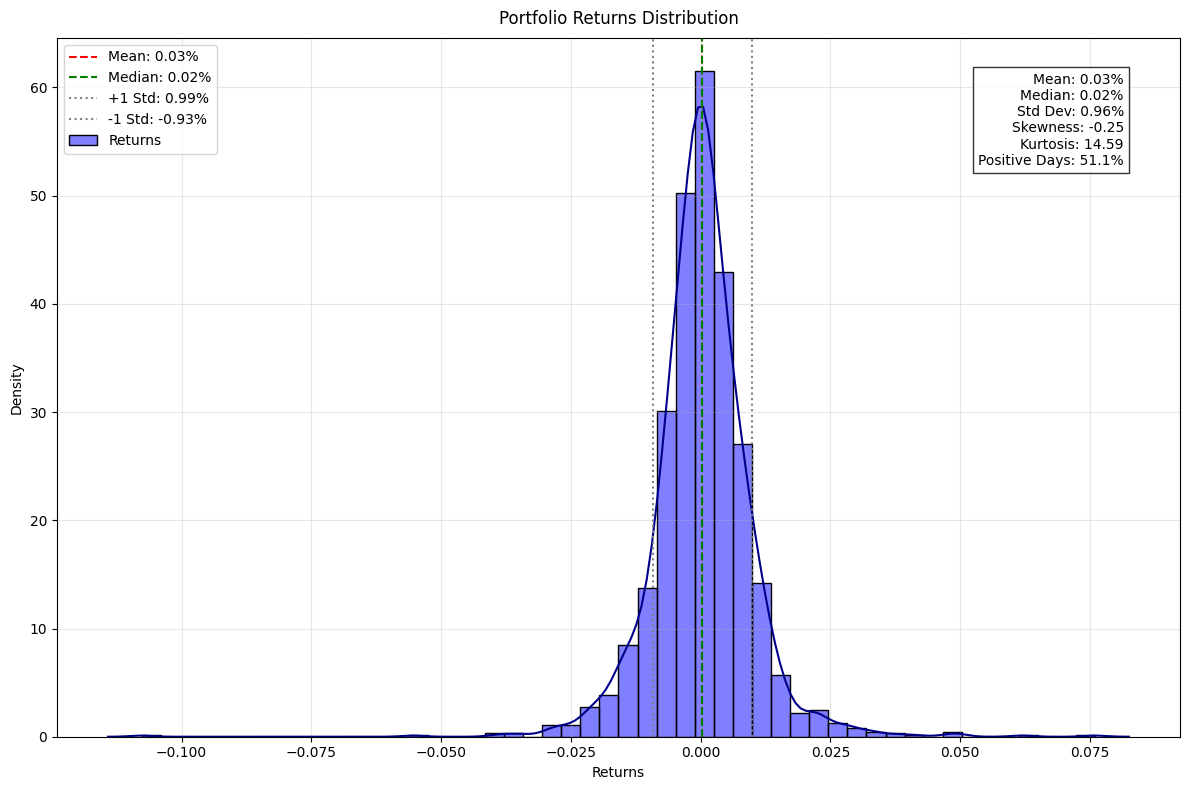

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


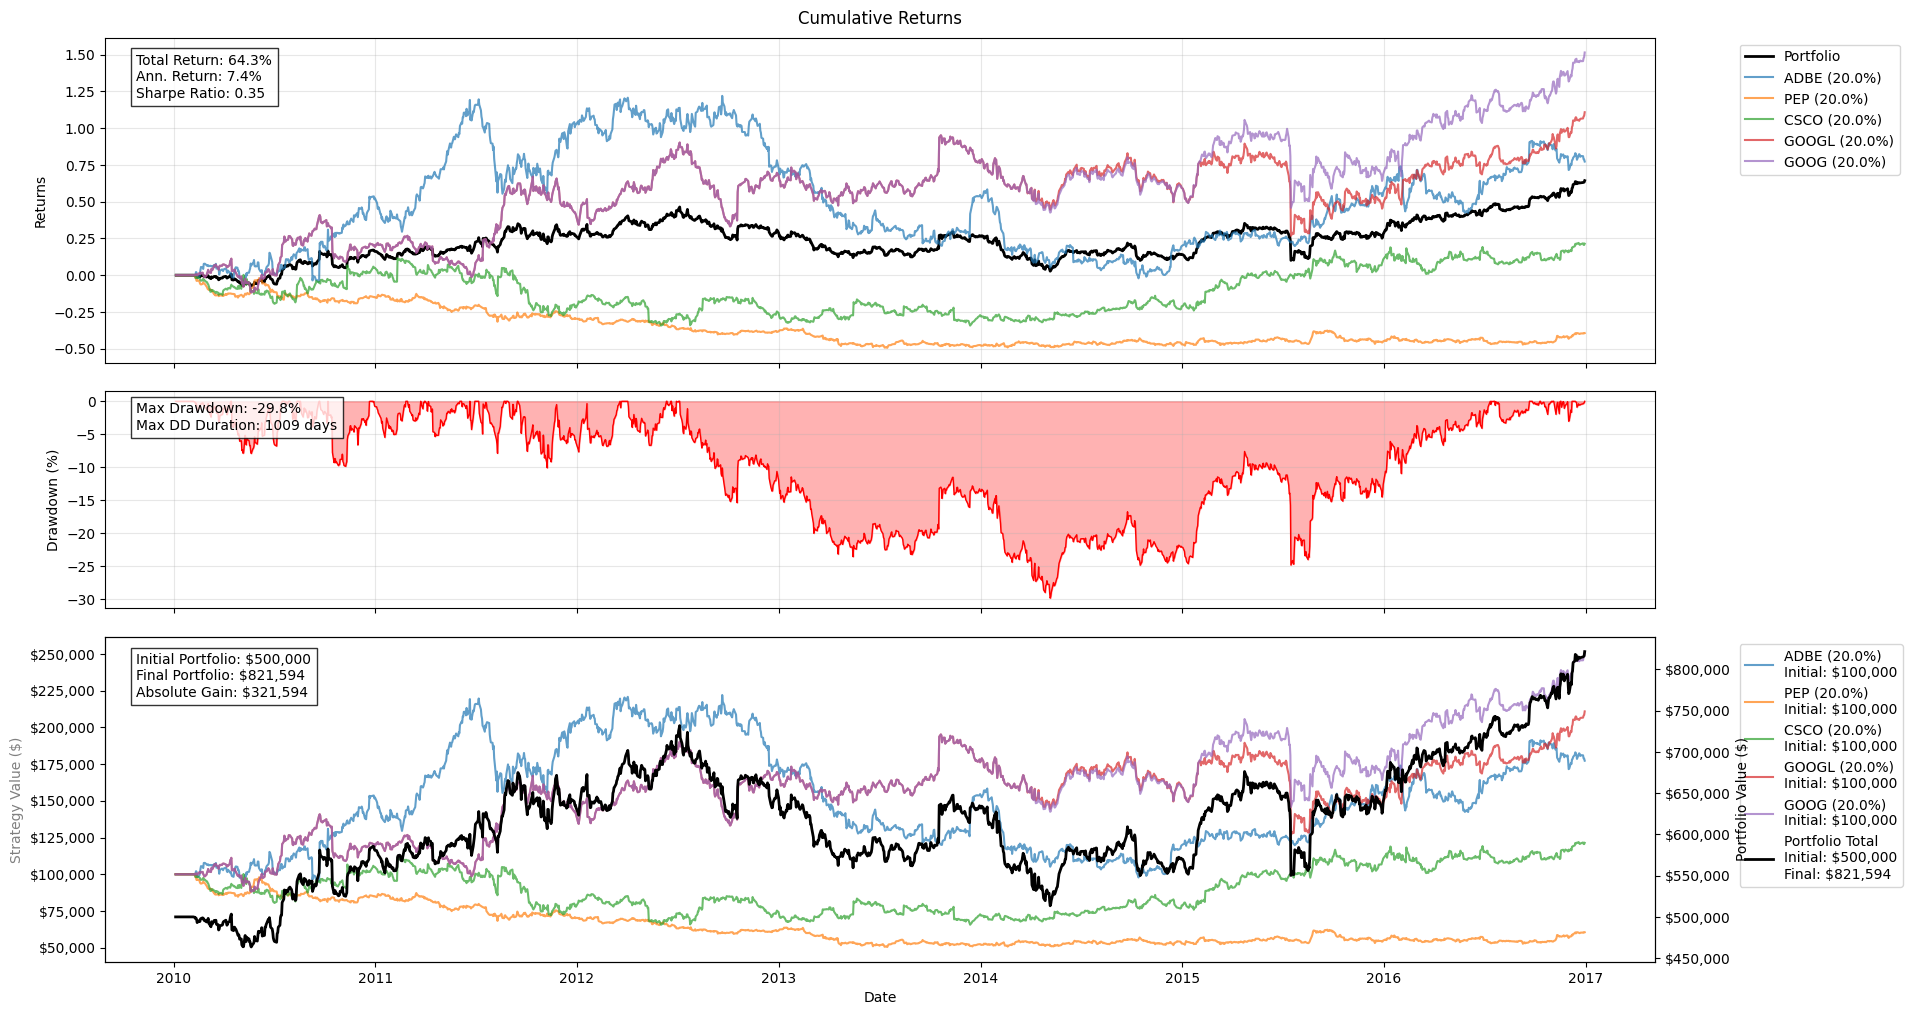

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


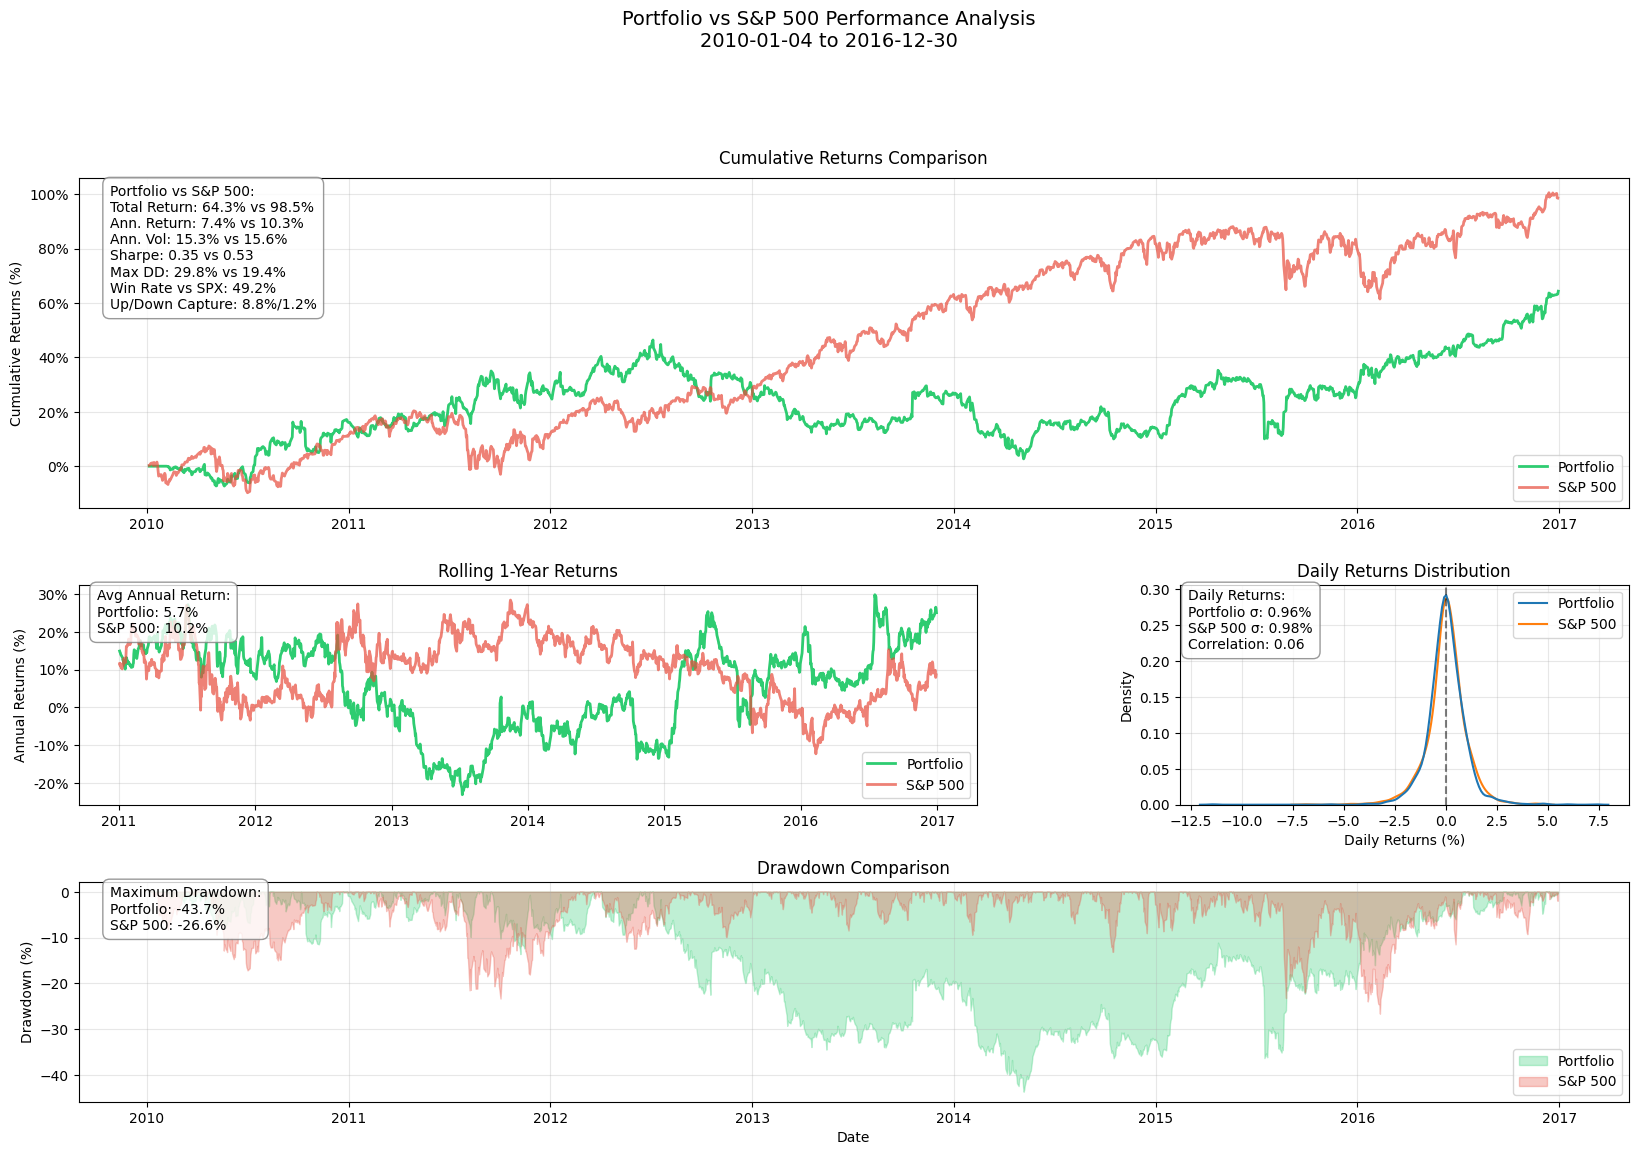

In [13]:
equalweightedportfolio_eventbasedbacktesters = []

for s in optimal_stock_lst:
    WeightedMCRSIStrategy_temp = WeightedMCRSIStrategy(
        symbol=s,
        start=train_start,
        end=train_end,
        interval=interval,
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    equalweightedportfolio_eventbasedbacktesters.append(WeightedMCRSIStrategy_temp)

# Create portfolio manager which will allocate capital
equalweightedportfolio_manager = EventBasedPortfolioManager(
    strategies=equalweightedportfolio_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=None  # Equal weights
)

# Run portfolio analysis
equalweightedportfolio_manager.run_portfolio()
equalweightedportfolio_manager.get_performance_metrics()
equalweightedportfolio_manager.print_benchmark_comparison()
# Plot results
equalweightedportfolio_manager.plot_portfolio_returns()
equalweightedportfolio_manager.plot_portfolio_performance()
# Plot comparison
equalweightedportfolio_manager.plot_benchmark_comparison()

## Modern Portfolio Theory and the Efficient Frontier to find optimal capital allocation for Training Date (2010-01-04 to 2016-12-30)

[*********************100%***********************]  5 of 5 completed


Max Sharpe Ratio Portfolio Weights: [0.12095756 0.01286253 0.04092522 0.09915746 0.72609723]
Minimum Risk Portfolio Weights: [0.00830673 0.0720297  0.09780268 0.02120953 0.80065136]
Maximum Return Portfolio Weights: [0.5475856157568555, 5.6496442555219816e-05, 0.037541743890304353, 0.3903821662922633, 0.024433977618021588]


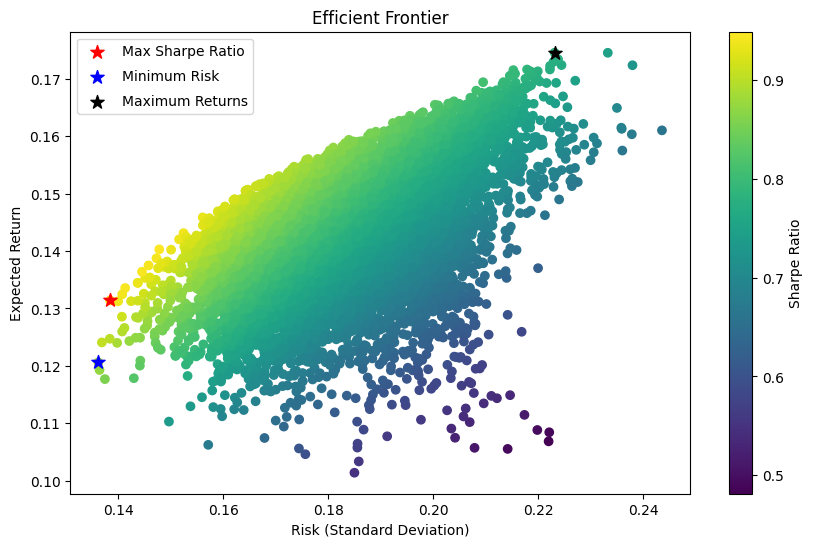

In [ ]:
# Step 1: Download data for selected assets
data = yf.download(optimal_stock_lst, start='2010-01-01', end='2016-12-31')['Adj Close']

# Step 2: Calculate expected returns and the covariance matrix
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252  # Annualized mean return
cov_matrix = returns.cov() * 252  # Annualized covariance matrix

# Step 3: Define the number of portfolios and arrays to store results
num_portfolios = 10000
results = np.zeros((3, num_portfolios)) # 3D matrix

# Portfolio weights matrix
weights_record = []

for i in range(num_portfolios):
    # Generate random weights
    weights = np.random.random(len(optimal_stock_lst))
    weights /= np.sum(weights)

    # Portfolio returns and risk (volatility)
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Store the results
    results[0, i] = portfolio_stddev
    results[1, i] = portfolio_return
    results[2, i] = results[1, i] / results[0, i]  # Sharpe Ratio
    weights_record.append(weights)

# Step 4: Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='o')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')

# Highlight the portfolio with the maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2, :])
plt.scatter(results[0, max_sharpe_idx], results[1, max_sharpe_idx], c='red', marker='*', s=100, label='Max Sharpe Ratio')

# Highlight the portfolio with the minimum rxwisk
min_risk_idx = np.argmin(results[0, :])
plt.scatter(results[0, min_risk_idx], results[1, min_risk_idx], c='blue', marker='*', s=100, label='Minimum Risk')


max_sharpe_weights = weights_record[max_sharpe_idx]
min_risk_weights = weights_record[min_risk_idx]

max_sharpe_weights_list = max_sharpe_weights.tolist()
min_risk_weights_list = min_risk_weights.tolist()

print("Max Sharpe Ratio Portfolio Weights:", max_sharpe_weights)
print("Minimum Risk Portfolio Weights:", min_risk_weights)

# Find the index of the maximum return
max_return_idx = np.argmax(results[1, :])

# Get the weights corresponding to the maximum return
max_return_weights = weights_record[max_return_idx]
max_return_weights_list = max_return_weights.tolist()
plt.scatter(results[0, max_return_idx], results[1, max_return_idx], c='black', marker='*', s=100, label='Maximum Returns')

# Print out the weights for the maximum return portfolio
print("Maximum Return Portfolio Weights:", max_return_weights_list)

plt.legend(labelspacing=0.8)
plt.title('Efficient Frontier')
plt.show()

In [23]:
results[0, max_sharpe_idx]

0.13846280932244834

In [24]:
results[0, min_risk_idx]

0.136227638882016

In [17]:
results[1, max_return_idx]

0.17704161100707375

In [18]:
# Max Sharpe Ratio Portfolio Weights
maxsharpe_train_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=train_start,
        end=train_end,
        interval=interval,
        transaction_fee=0.001,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    maxsharpe_train_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)

# Create portfolio manager which will allocate capital
maxsharpeportfolio_train_manager = EventBasedPortfolioManager(
    strategies=maxsharpe_train_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=max_sharpe_weights_list  # Max Sharpe weights
)

# Run portfolio analysis
maxsharpeportfolio_train_manager.run_portfolio()
maxsharpeportfolio_train_manager.get_performance_metrics()
maxsharpeportfolio_train_manager.print_benchmark_comparison()


Portfolio vs S&P 500 Comparison (2010-01-04 to 2016-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                   128.87%       98.52%       30.35%       30.80%
Annual Return                   12.58%       10.32%        2.26%       21.93%
Annual Volatility               22.71%       15.56%        7.15%       45.93%
Sharpe Ratio                     0.47        0.53       -0.07      -12.84%
Sortino Ratio                    0.45        0.50       -0.05      -10.60%
Max Drawdown                    28.62%       19.39%        9.23%       47.62%
Win Rate                        51.11%       54.20%       -3.10%       -5.71%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: 0.03
Tracking Error: 27.20%
Information Ratio: 0.08

Market Capture Metrics:
-----------------------

## Highest Sharpe on Test Data (2017-01-01 to 2019-01-01)


Portfolio vs S&P 500 Comparison (2017-01-03 to 2019-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                    -5.83%       43.50%      -49.33%     -113.41%
Annual Return                   -1.99%       12.88%      -14.88%     -115.48%
Annual Volatility               19.71%       12.84%        6.87%       53.50%
Sharpe Ratio                    -0.20        0.85       -1.05     -123.91%
Sortino Ratio                   -0.20        0.76       -0.96     -125.78%
Max Drawdown                    25.15%       19.78%        5.37%       27.17%
Win Rate                        47.87%       56.32%       -8.45%      -15.01%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: 0.07
Tracking Error: 22.72%
Information Ratio: -0.65

Market Capture Metrics:
----------------------

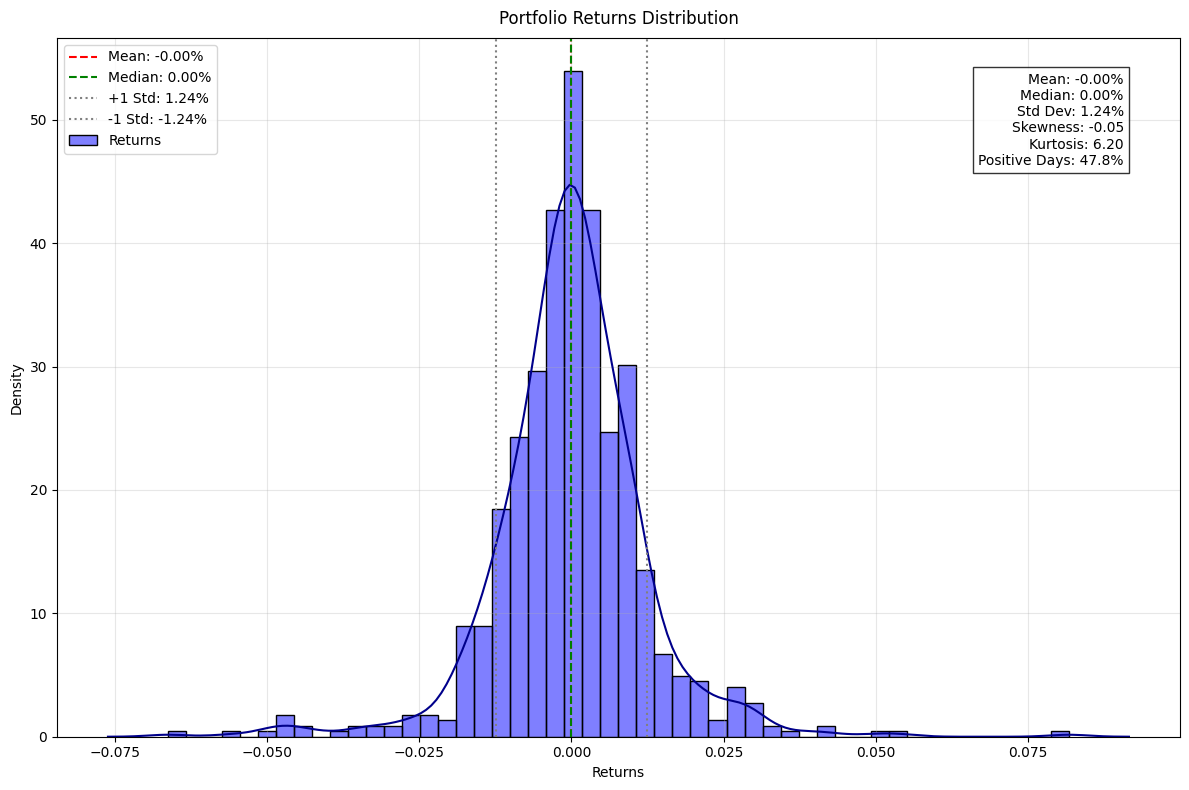

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


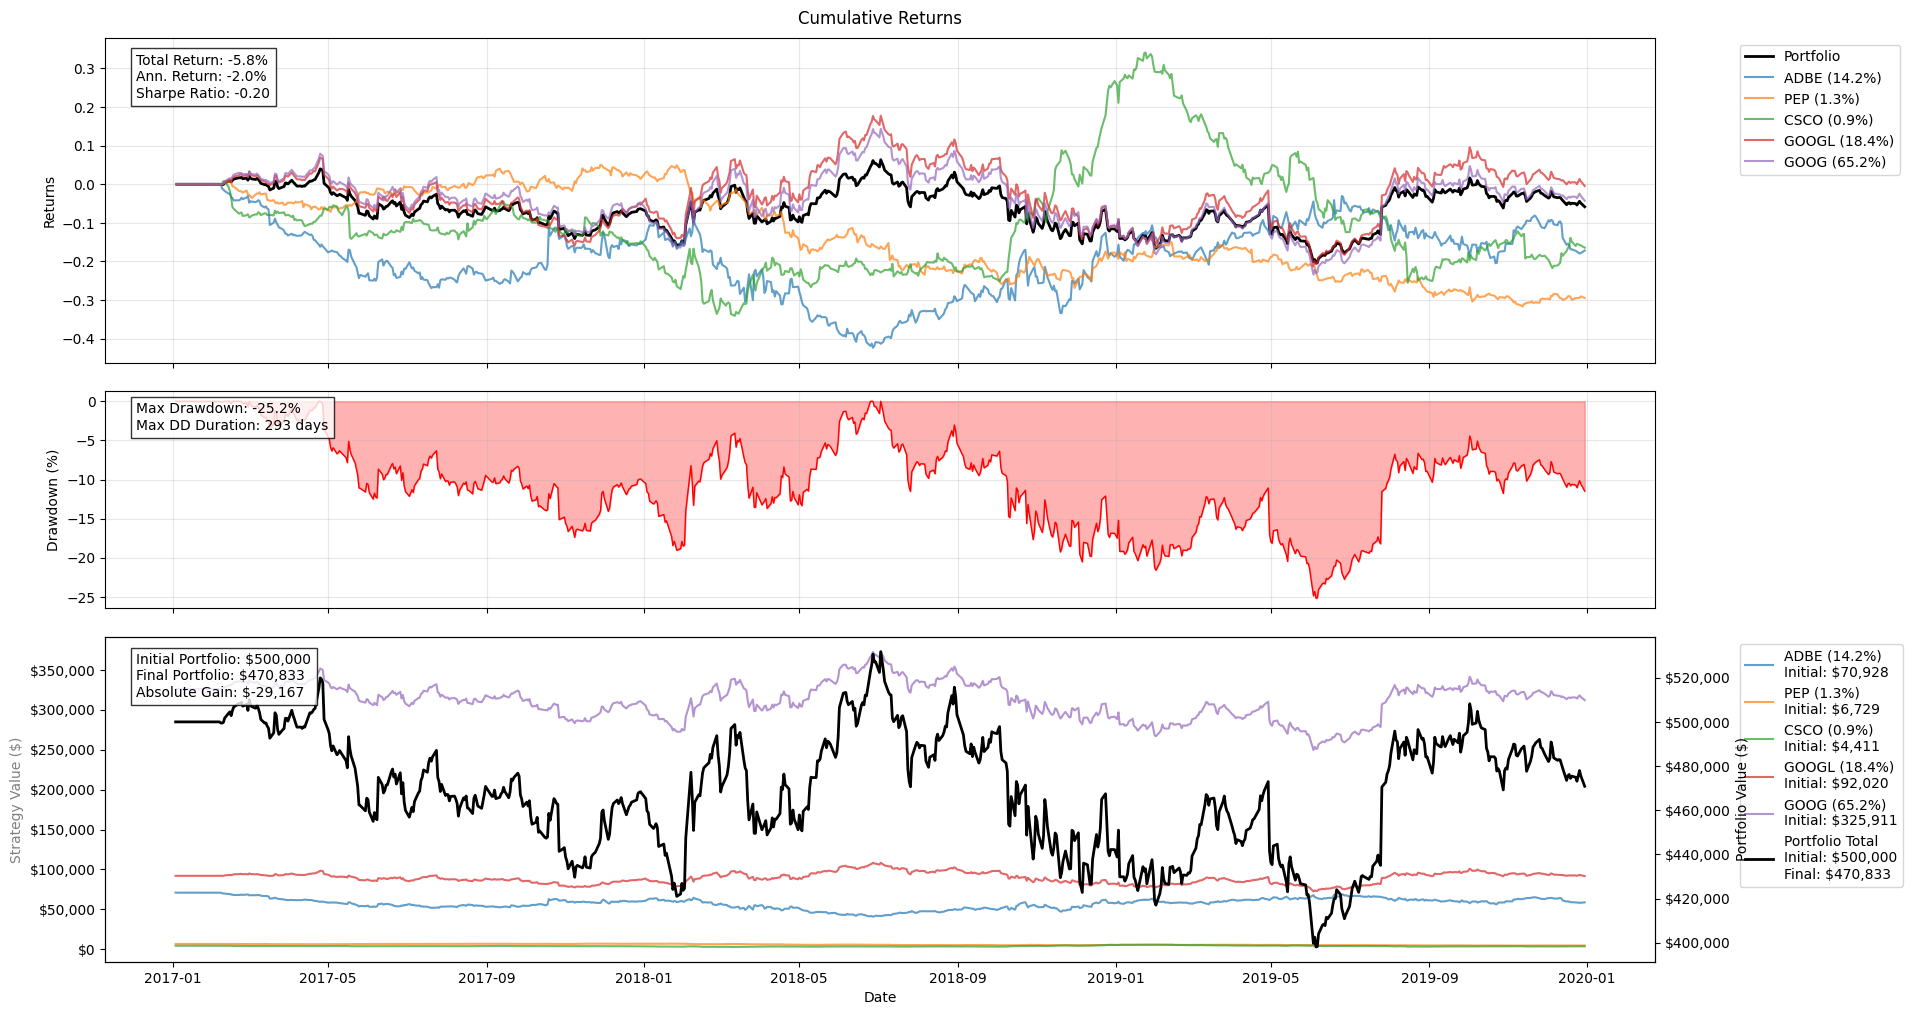

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


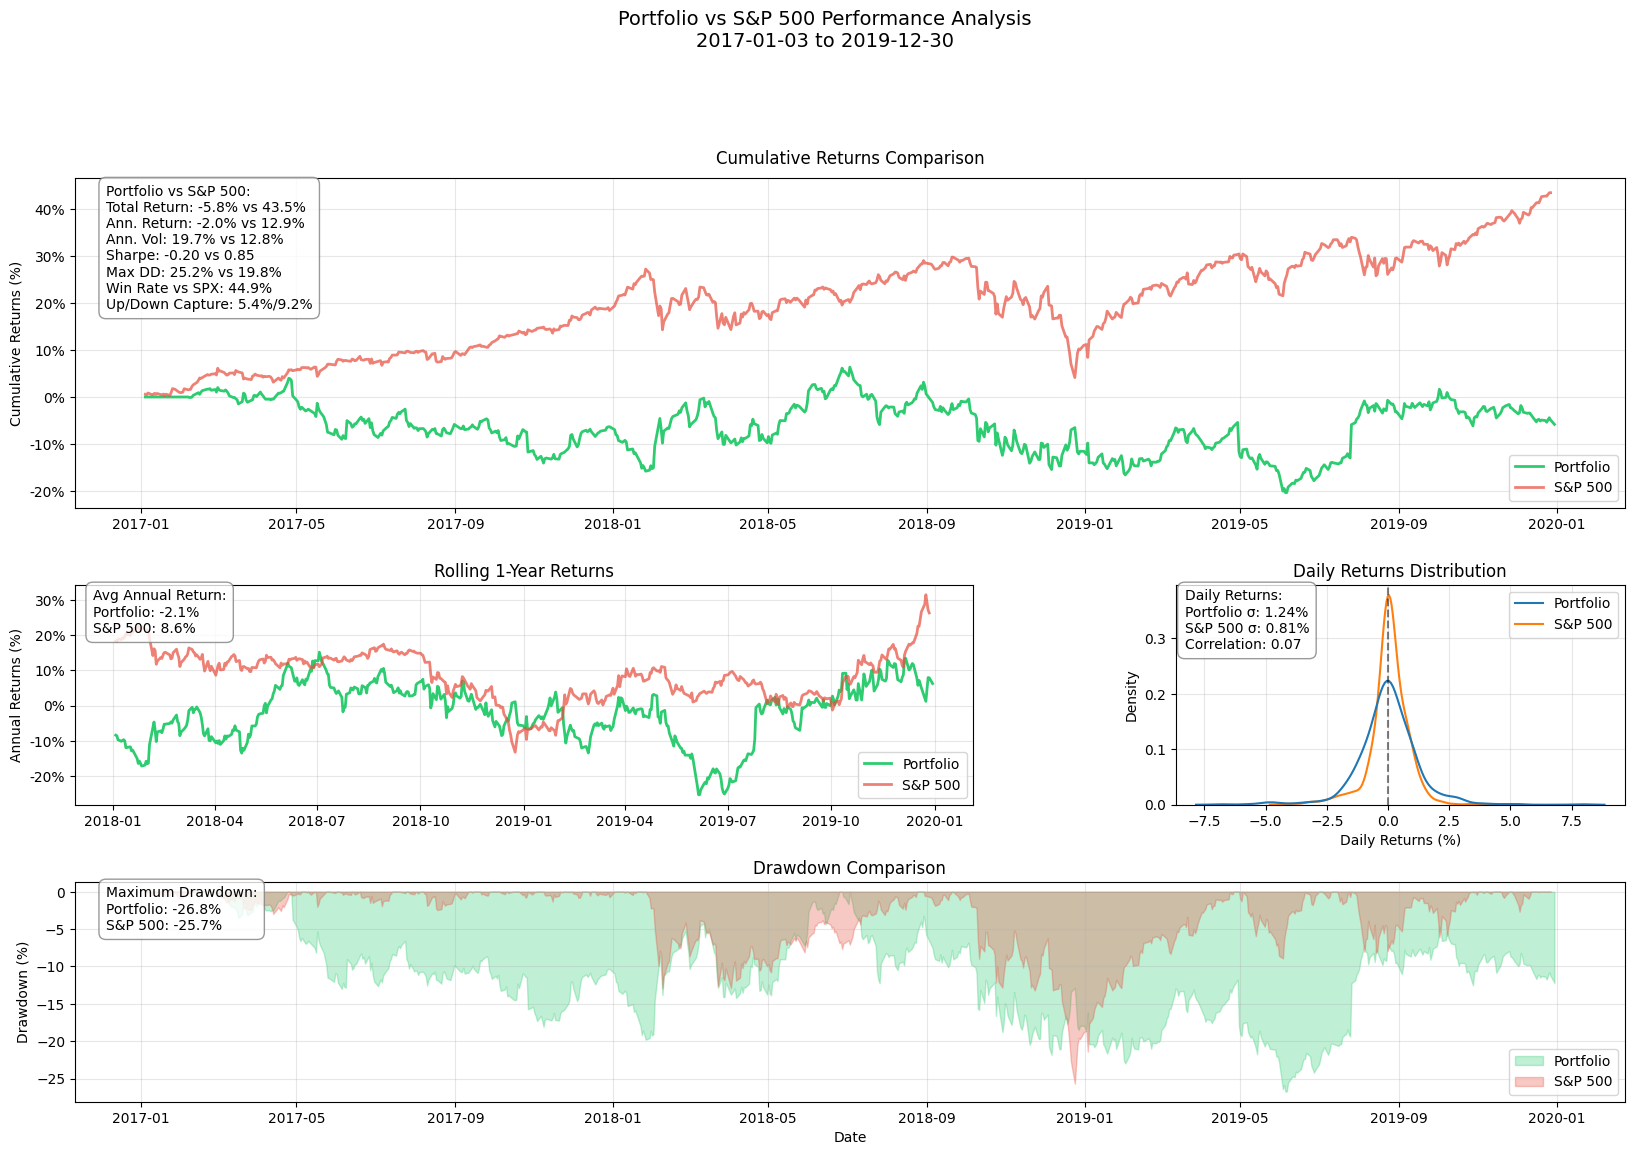

In [19]:
test_start = '2017-01-01'
test_end = '2019-12-31'
interval = '1d'
fees = 0.001

# Max Sharpe Ratio Portfolio Weights
maxsharpe_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval=interval,
        transaction_fee=fees,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    maxsharpe_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)

# Create portfolio manager which will allocate capital
maxsharpeportfolio_manager = EventBasedPortfolioManager(
    strategies=maxsharpe_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=max_sharpe_weights_list  # Max Sharpe weights
)

# Run portfolio analysis
maxsharpeportfolio_manager.run_portfolio()
maxsharpeportfolio_manager.get_performance_metrics()
maxsharpeportfolio_manager.print_benchmark_comparison()
# Plot results
maxsharpeportfolio_manager.plot_portfolio_returns()
maxsharpeportfolio_manager.plot_portfolio_performance()
# Plot comparison
maxsharpeportfolio_manager.plot_benchmark_comparison()

## Lowest Risk on Test Data (2017-01-01 to 2019-01-01)

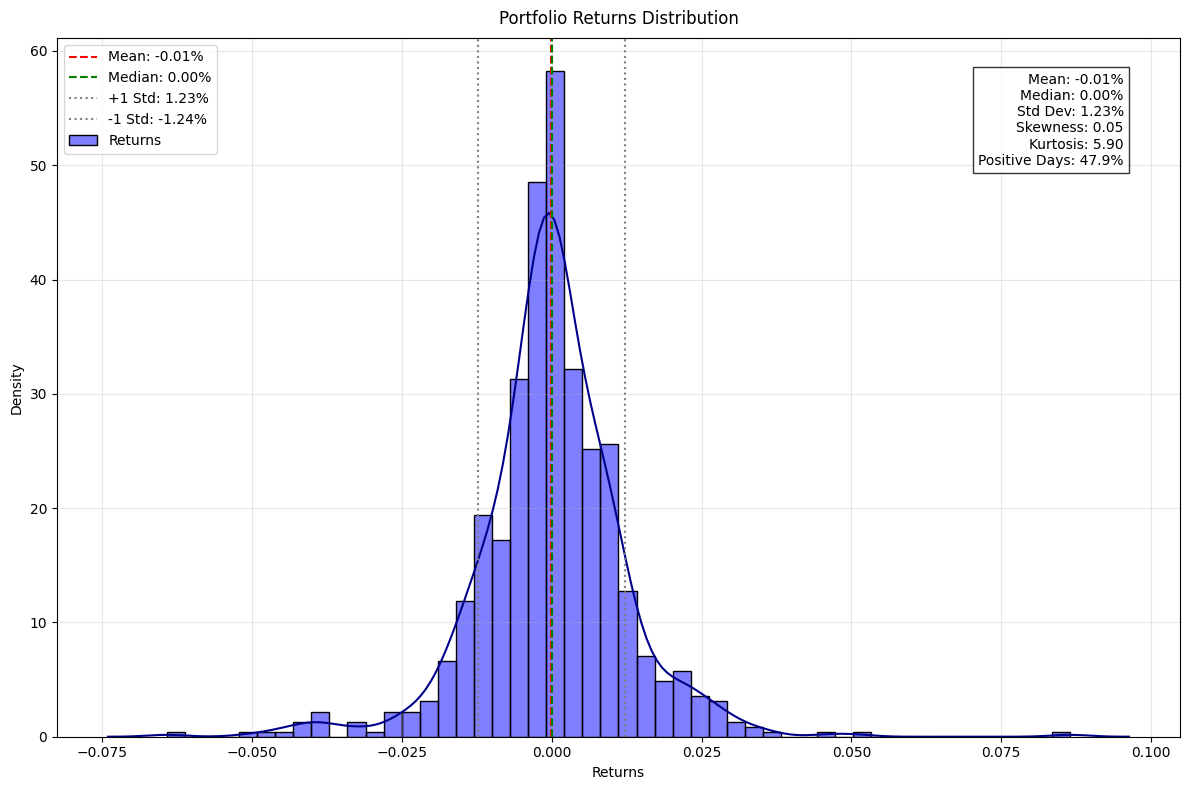

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


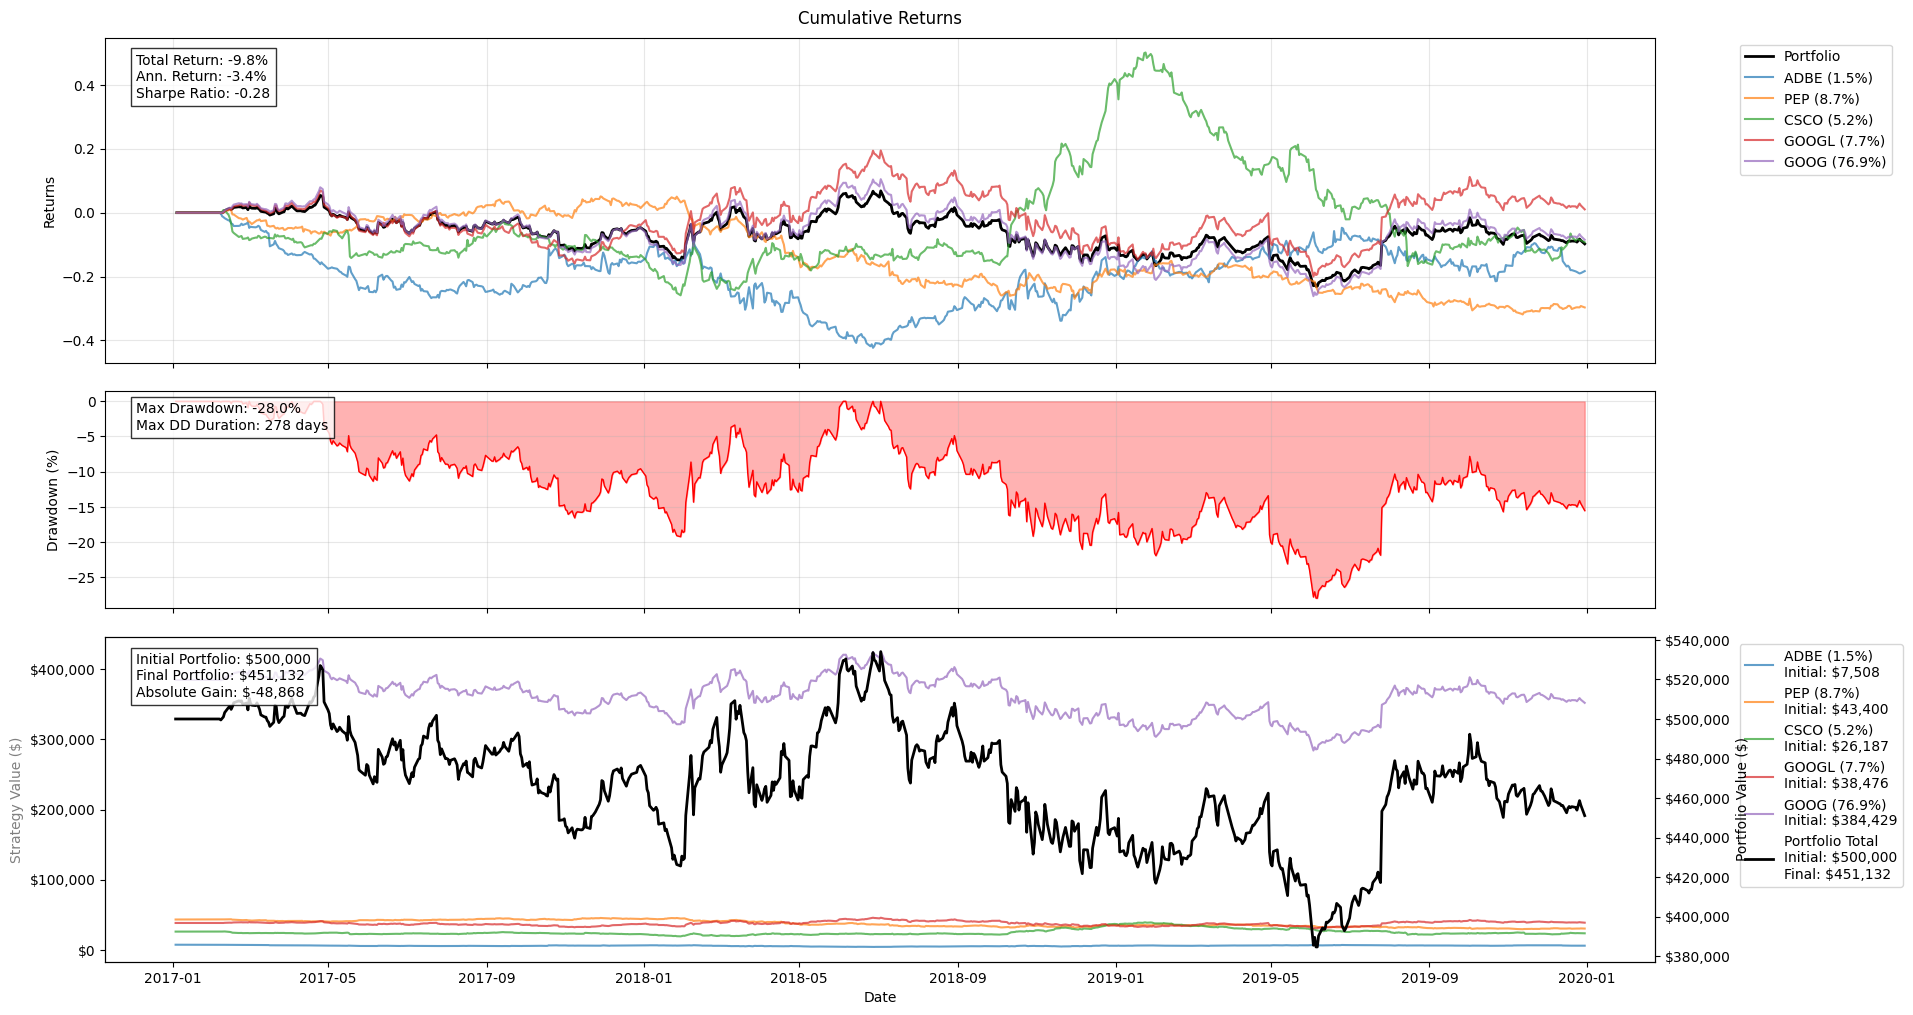

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


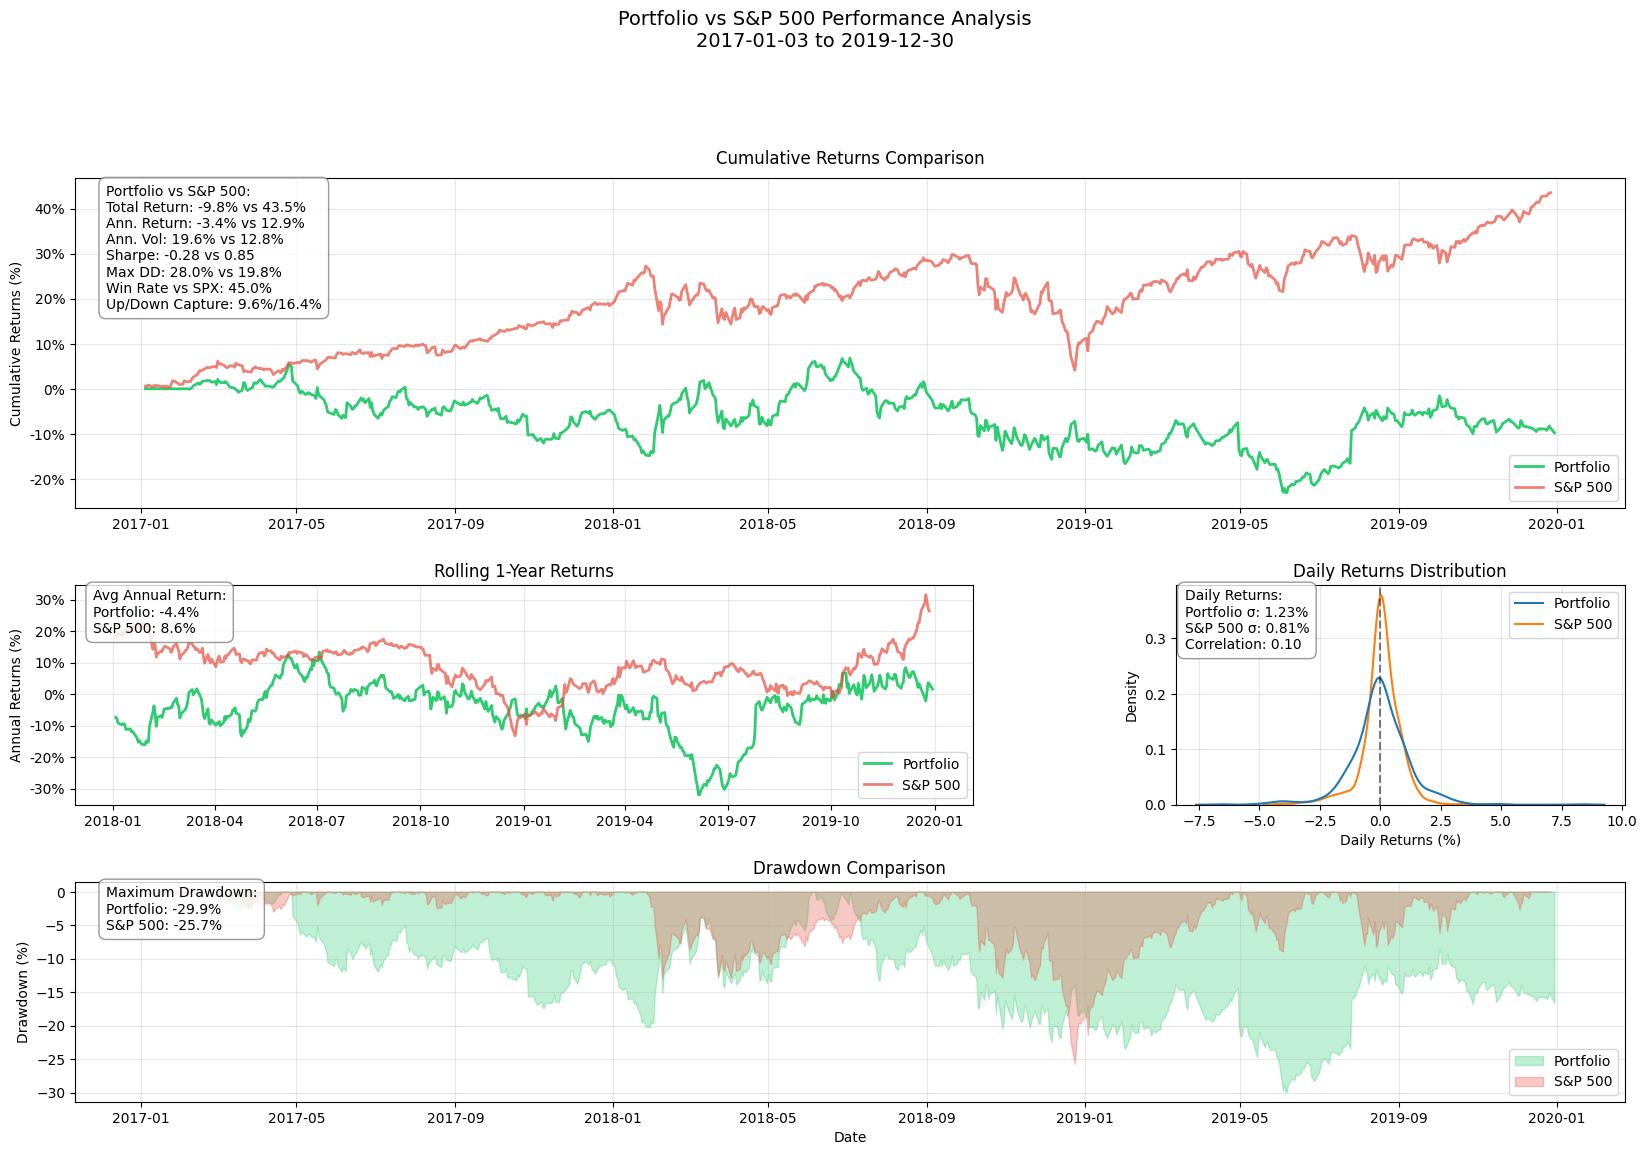


Portfolio vs S&P 500 Comparison (2017-01-03 to 2019-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                    -9.77%       43.50%      -53.28%     -122.47%
Annual Return                   -3.39%       12.88%      -16.27%     -126.29%
Annual Volatility               19.56%       12.84%        6.71%       52.27%
Sharpe Ratio                    -0.28        0.85       -1.12     -132.51%
Sortino Ratio                   -0.27        0.76       -1.03     -135.02%
Max Drawdown                    27.96%       19.78%        8.18%       41.38%
Win Rate                        48.01%       56.32%       -8.32%      -14.77%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: 0.10
Tracking Error: 22.28%
Information Ratio: -0.73

Market Capture Metrics:
----------------------

In [20]:
# Minimum Risk Portfolio Weights

lowestrisk_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval=interval,
        transaction_fee=fees,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    lowestrisk_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)

# Create portfolio manager which will allocate capital
lowestriskportfolio_manager = EventBasedPortfolioManager(
    strategies=lowestrisk_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=min_risk_weights_list  # Lowest Risk weights
)

# Run portfolio analysis
lowestriskportfolio_manager.run_portfolio()
lowestriskportfolio_manager.get_performance_metrics()
lowestriskportfolio_manager.plot_portfolio_returns()
lowestriskportfolio_manager.plot_portfolio_performance()
# Plot comparison
lowestriskportfolio_manager.plot_benchmark_comparison()

# Print detailed statistics
lowestriskportfolio_manager.print_benchmark_comparison()

## Highest Expected Returns on Test Data (2017-01-01 to 2019-01-01)

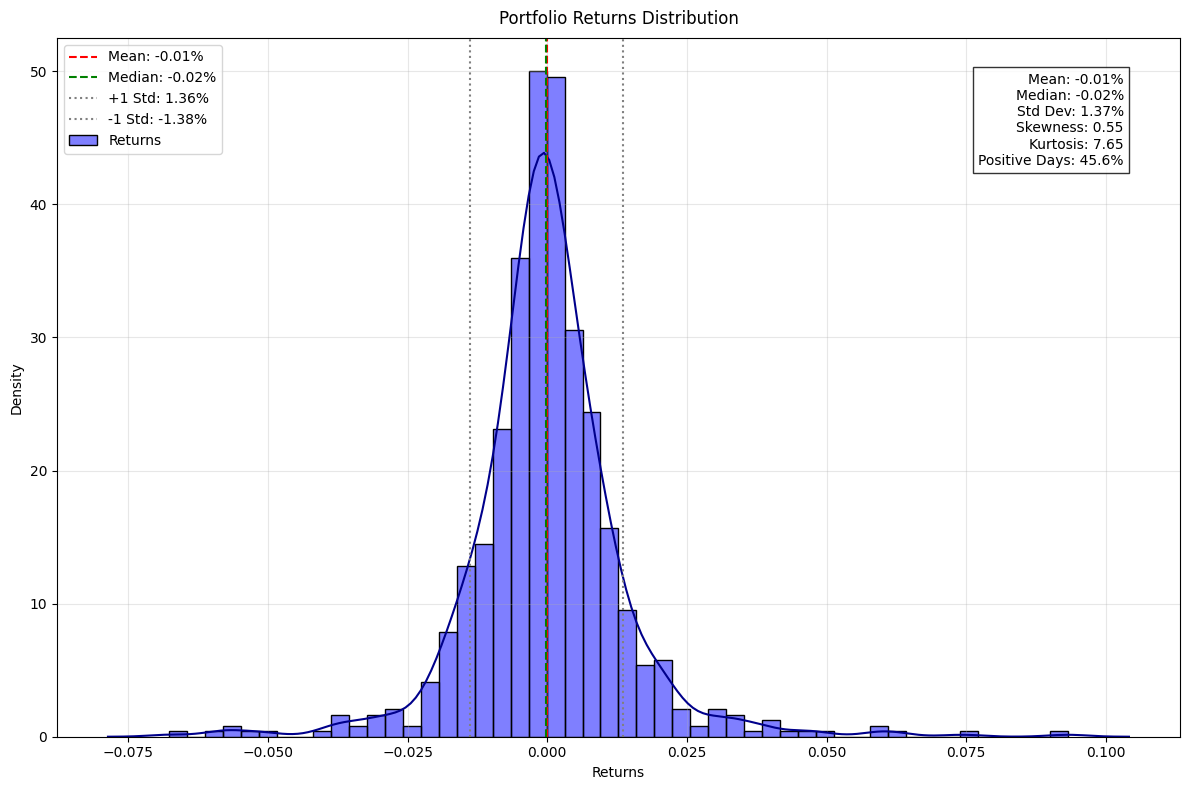

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:506: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


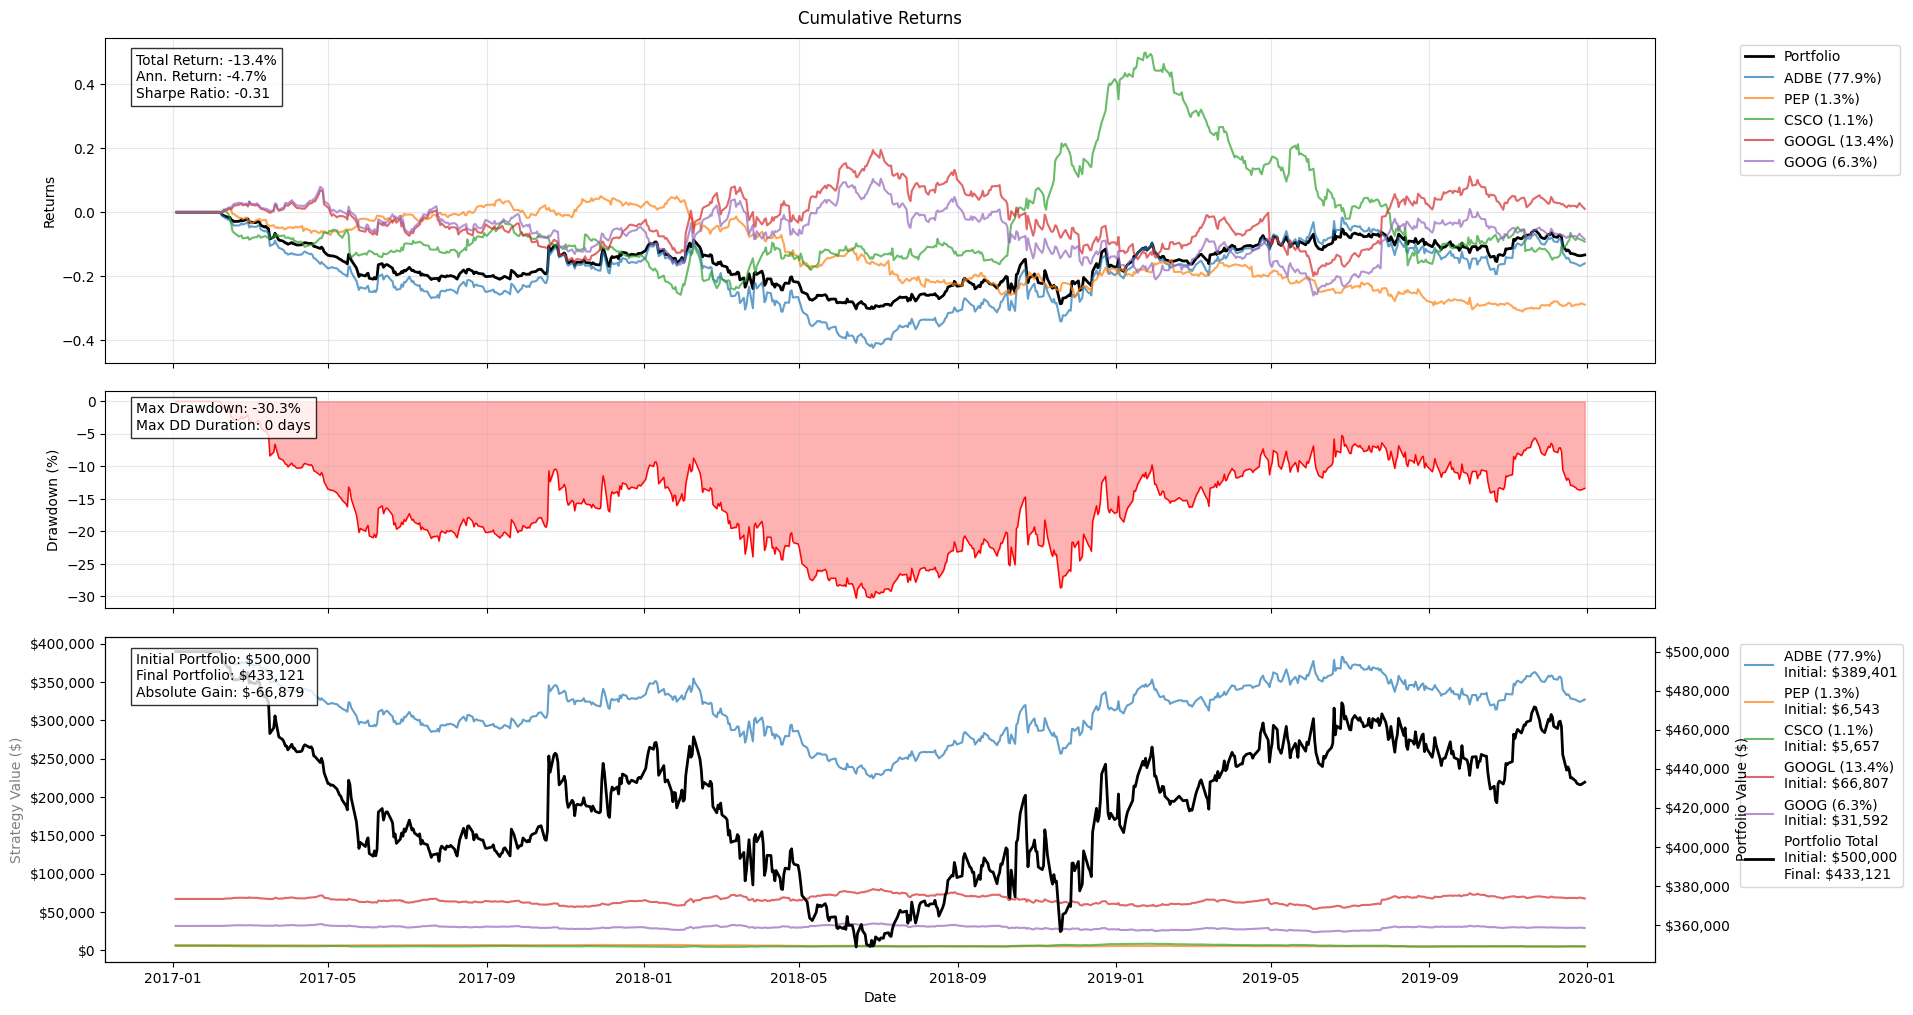

/var/folders/76/sv22wlqx51l_7wpcjlt9ds2c0000gn/T/ipykernel_15020/1012208466.py:705: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


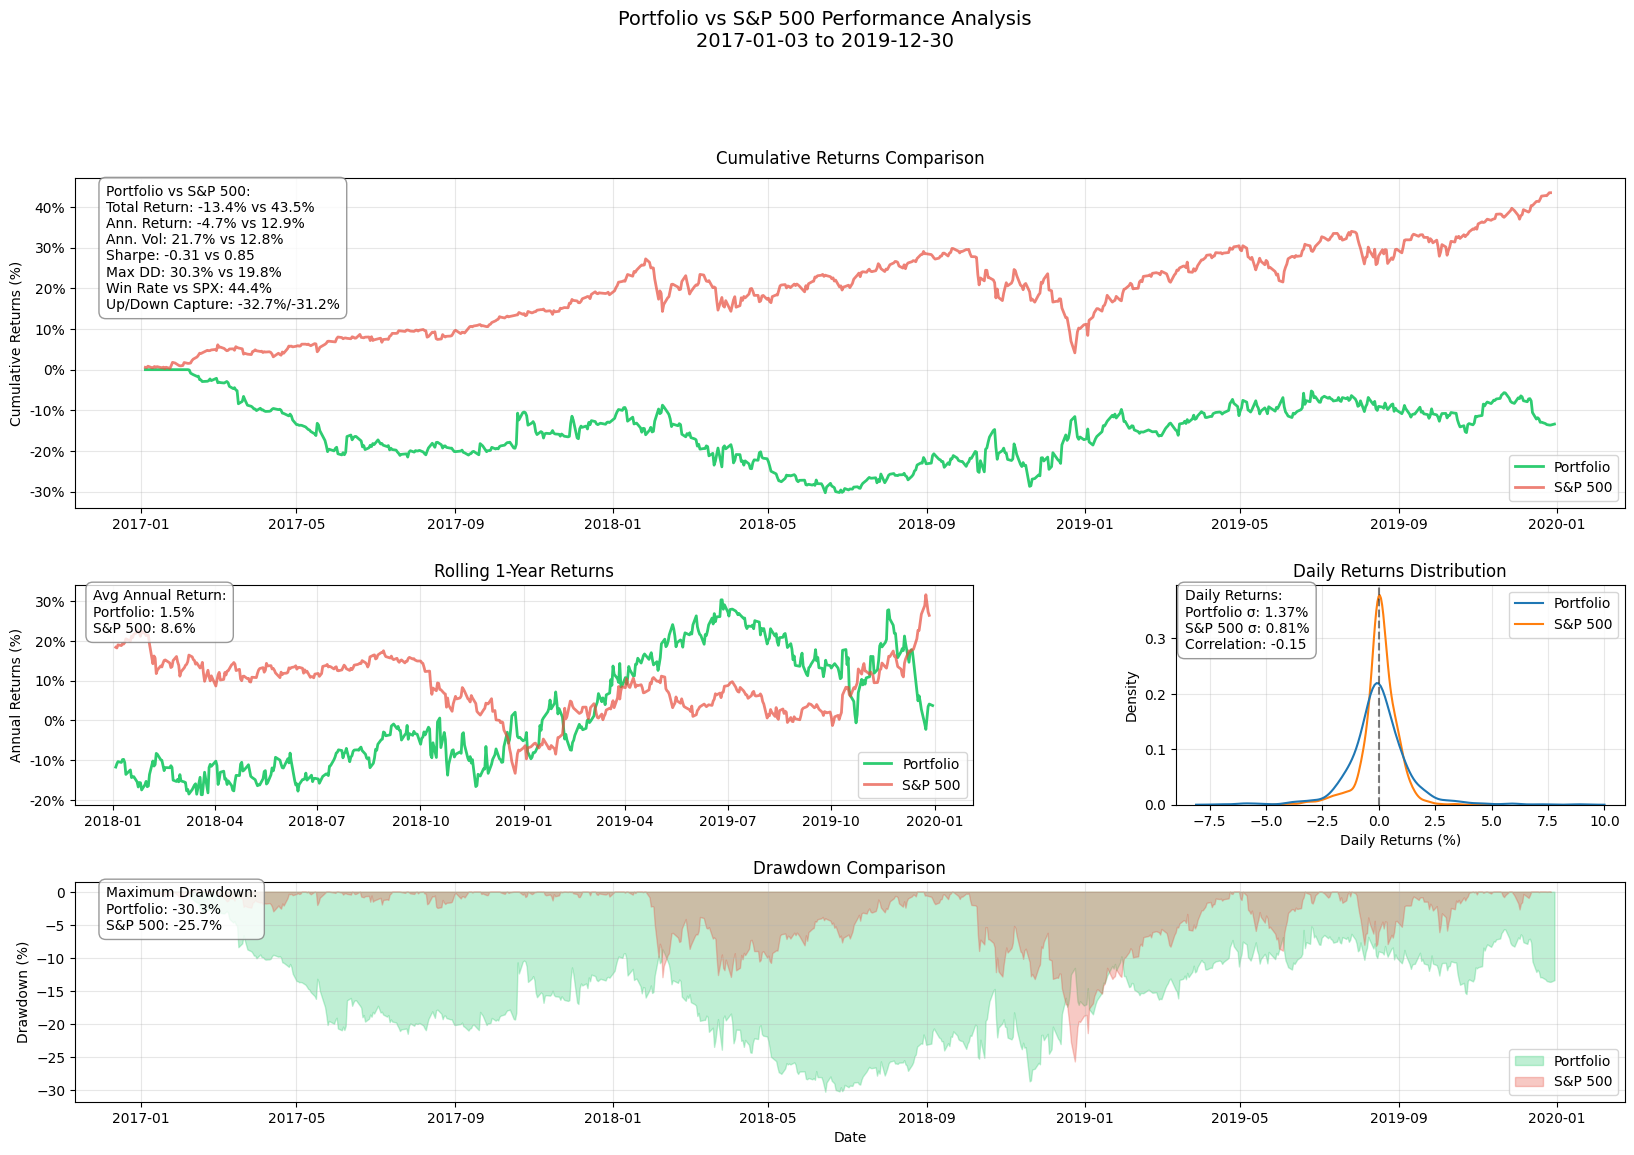


Portfolio vs S&P 500 Comparison (2017-01-03 to 2019-12-30)

Performance Metrics:
Metric                       Portfolio      S&P 500       Active       % Diff
--------------------------------------------------------------------------------
Total Return                   -13.38%       43.50%      -56.88%     -130.75%
Annual Return                   -4.70%       12.88%      -17.58%     -136.46%
Annual Volatility               21.73%       12.84%        8.89%       69.20%
Sharpe Ratio                    -0.31        0.85       -1.16     -136.37%
Sortino Ratio                   -0.32        0.76       -1.08     -141.89%
Max Drawdown                    30.26%       19.78%       10.48%       52.97%
Win Rate                        45.61%       56.32%      -10.71%      -19.02%

Risk Metrics:
--------------------------------------------------------------------------------
Beta: nan
Correlation: -0.15
Tracking Error: 26.81%
Information Ratio: -0.66

Market Capture Metrics:
---------------------

In [21]:
# Max Returns Weights

highestreturns_eventbasedbacktesters = []

for s in optimal_stock_lst:
    OptimalWeightedMCRSIStrategy_test = WeightedMCRSIStrategy(
        symbol=s,
        start=test_start,
        end=test_end,
        interval=interval,
        transaction_fee=fees,
        verbose=False,
        rsi_periods=optimal_rsi_window,
        qqq_components=qqq_components
    )
    highestreturns_eventbasedbacktesters.append(OptimalWeightedMCRSIStrategy_test)

# Create portfolio manager which will allocate capital
highestreturnsportfolio_manager = EventBasedPortfolioManager(
    strategies=highestreturns_eventbasedbacktesters,
    total_capital=total_capital,  # Total portfolio capital
    weights=max_return_weights_list  # Highest Returns weights
)

# Run portfolio analysis
highestreturnsportfolio_manager.run_portfolio()
highestreturnsportfolio_manager.get_performance_metrics()
highestreturnsportfolio_manager.plot_portfolio_returns()
highestreturnsportfolio_manager.plot_portfolio_performance()
# Plot comparison
highestreturnsportfolio_manager.plot_benchmark_comparison()

# Print detailed statistics
highestreturnsportfolio_manager.print_benchmark_comparison()